# TESS Atlas fit for TOI 510

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 510.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-510.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-510.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-510.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 510

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 510 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

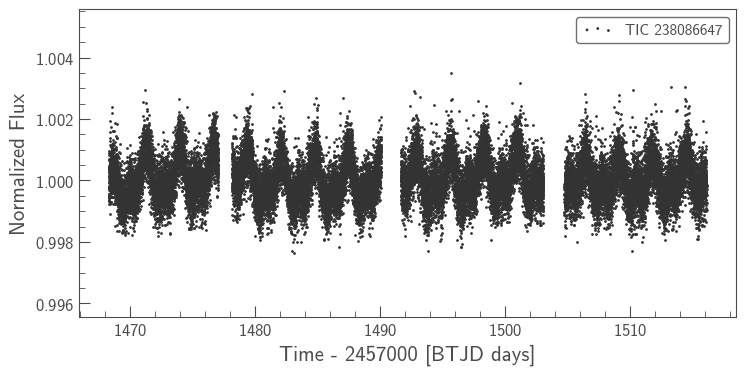

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -46319.66287840951 -> -36862.82186987402


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -28259.677754640586 -> -23847.978307720095


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -23847.9783077201 -> -23545.621107215386


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -23545.621107215386 -> -23545.438613129925


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -23545.438613129925 -> -23543.501976282616


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -23543.501976282616 -> -23543.339007941486


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -23543.339007941486 -> -23536.48104632878


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -23536.48104632878 -> -23536.48104632878


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -23536.48104632878 -> -23536.48104632878


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -23536.48104632878 -> -23536.48104632878


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -23536.48104632878 -> -23536.48104632878


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -23536.48104632878 -> -23536.48104632878


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -23536.48104632878 -> -23536.48104632878


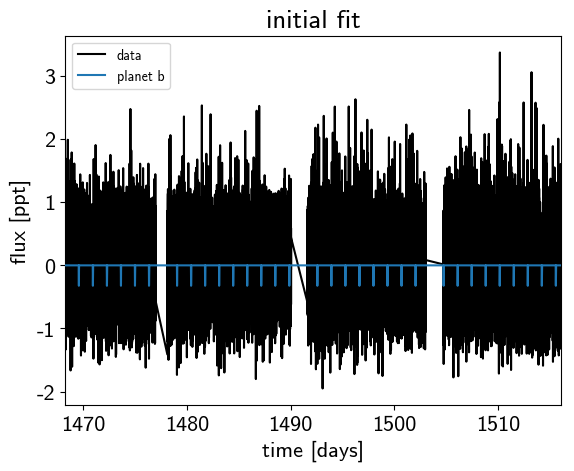

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   8%|▊         | 8/104 [00:00<00:01, 77.26draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:02<00:21,  4.24draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:03<00:30,  2.99draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:04<00:36,  2.47draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:04<00:30,  2.92draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:05<00:45,  1.92draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:06<00:38,  2.24draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:06<00:47,  1.79draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:07<00:43,  1.94draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:08<00:48,  1.71draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:08<00:45,  1.79draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:09<00:46,  1.73draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:09<00:47,  1.67draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:10<00:44,  1.78draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:11<00:49,  1.58draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:11<00:42,  1.83draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:12<00:50,  1.50draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:12<00:38,  1.93draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:13<00:53,  1.38draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:15<00:51,  1.40draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:16<00:48,  1.45draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:16<00:36,  1.91draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:17<00:45,  1.48draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:17<00:36,  1.82draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:18<00:43,  1.52draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:19<00:37,  1.74draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:19<00:40,  1.56draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:20<00:39,  1.60draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:21<00:37,  1.67draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:22<00:45,  1.35draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:23<00:40,  1.46draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:23<00:34,  1.69draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:24<00:35,  1.59draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:24<00:36,  1.55draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:25<00:32,  1.70draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:26<00:37,  1.45draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:26<00:28,  1.87draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:27<00:36,  1.42draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:28<00:33,  1.51draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:29<00:27,  1.79draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:29<00:30,  1.56draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:30<00:28,  1.64draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:30<00:27,  1.68draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:31<00:29,  1.50draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:32<00:23,  1.83draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:33<00:30,  1.40draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:34<00:28,  1.45draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:34<00:20,  1.94draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:35<00:28,  1.37draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:36<00:21,  1.74draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:37<00:27,  1.37draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:37<00:22,  1.57draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:38<00:24,  1.42draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:39<00:24,  1.37draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:39<00:22,  1.46draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:40<00:23,  1.34draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:41<00:20,  1.49draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:42<00:22,  1.36draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:42<00:18,  1.54draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:43<00:21,  1.31draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:43<00:15,  1.69draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:45<00:22,  1.18draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:45<00:15,  1.57draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:46<00:20,  1.20draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:47<00:16,  1.37draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:48<00:18,  1.21draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:48<00:14,  1.41draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:49<00:15,  1.25draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:50<00:14,  1.36draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:50<00:13,  1.33draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:51<00:12,  1.35draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:52<00:11,  1.34draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:53<00:11,  1.34draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:53<00:09,  1.42draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:54<00:09,  1.36draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:55<00:09,  1.29draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:56<00:08,  1.35draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:57<00:08,  1.25draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:57<00:06,  1.39draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:58<00:05,  1.36draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:59<00:04,  1.41draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [01:00<00:05,  1.06draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [01:01<00:05,  1.08s/draws]

Sampling 2 chains:  96%|█████████▌| 100/104 [01:03<00:04,  1.18s/draws]

Sampling 2 chains:  97%|█████████▋| 101/104 [01:03<00:02,  1.03draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [01:04<00:01,  1.04draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [01:06<00:01,  1.09s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:12<00:00,  2.73s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   8%|▊         | 8/104 [00:00<00:01, 74.85draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:16,  5.50draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:03<00:30,  2.98draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:04<00:38,  2.31draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:04<00:36,  2.44draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:05<00:49,  1.76draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:06<00:51,  1.67draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:07<00:51,  1.65draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:07<00:57,  1.47draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:08<00:51,  1.62draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:09<01:00,  1.34draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:09<00:51,  1.58draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:10<00:44,  1.79draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:11<00:54,  1.44draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:11<00:49,  1.58draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:12<00:53,  1.44draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:13<00:54,  1.40draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:13<00:49,  1.51draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:15<01:03,  1.17draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:16<00:57,  1.26draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:17<00:50,  1.40draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:17<00:42,  1.62draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:18<00:50,  1.36draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:19<00:39,  1.68draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:20<00:52,  1.26draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:20<00:42,  1.52draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:21<00:48,  1.31draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:22<00:44,  1.41draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:22<00:43,  1.41draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:23<00:44,  1.38draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:24<00:41,  1.46draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:25<00:45,  1.30draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:25<00:40,  1.42draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:27<00:51,  1.10draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:28<00:46,  1.17draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:28<00:34,  1.55draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:29<00:26,  2.00draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:30<00:36,  1.43draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:30<00:34,  1.49draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:31<00:33,  1.48draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:32<00:36,  1.33draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:32<00:32,  1.48draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:34<00:41,  1.14draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:34<00:29,  1.55draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:35<00:38,  1.18draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:36<00:31,  1.38draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:37<00:34,  1.25draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:37<00:31,  1.33draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:38<00:30,  1.34draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:39<00:31,  1.27draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:39<00:25,  1.52draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:41<00:32,  1.18draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:41<00:26,  1.35draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:42<00:21,  1.59draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:43<00:26,  1.29draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:43<00:19,  1.67draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:45<00:26,  1.20draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:46<00:23,  1.28draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:46<00:18,  1.60draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:47<00:20,  1.36draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:48<00:17,  1.51draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:48<00:17,  1.46draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:49<00:15,  1.56draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:50<00:15,  1.55draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:50<00:14,  1.58draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:51<00:13,  1.61draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:52<00:10,  1.85draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:53<00:11,  1.60draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:53<00:12,  1.48draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:54<00:10,  1.69draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:55<00:12,  1.32draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:56<00:10,  1.40draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:56<00:07,  1.71draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:57<00:08,  1.43draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:58<00:07,  1.49draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:59<00:07,  1.30draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:59<00:06,  1.45draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [01:00<00:06,  1.27draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [01:01<00:05,  1.32draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [01:03<00:05,  1.00draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [01:03<00:03,  1.28draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [01:04<00:03,  1.09draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [01:06<00:03,  1.06s/draws]

Sampling 2 chains:  98%|█████████▊| 102/104 [01:07<00:02,  1.17s/draws]

Sampling 2 chains:  99%|█████████▉| 103/104 [01:08<00:01,  1.25s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:15<00:00,  2.81s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:01<04:45,  1.41s/draws]

Sampling 2 chains:   1%|▏         | 3/204 [00:01<03:25,  1.02s/draws]

Sampling 2 chains:   2%|▏         | 5/204 [00:02<02:51,  1.16draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:03<02:32,  1.30draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:03<01:54,  1.73draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:03<01:48,  1.81draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:03<01:22,  2.36draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:04<01:08,  2.85draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:04<01:17,  2.48draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:05<01:36,  2.00draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:06<01:46,  1.80draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:06<02:00,  1.58draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:07<02:10,  1.45draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:08<02:19,  1.35draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:09<02:19,  1.34draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:10<02:28,  1.25draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:11<02:25,  1.27draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:11<01:47,  1.72draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:11<01:54,  1.60draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:13<02:03,  1.46draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:13<01:32,  1.93draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:15<02:18,  1.28draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:15<02:01,  1.45draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:16<02:22,  1.24draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:17<02:23,  1.22draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:17<02:01,  1.43draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:19<02:03,  1.39draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:19<01:34,  1.81draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:21<02:20,  1.21draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:21<01:50,  1.52draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:23<02:42,  1.03draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:25<02:36,  1.06draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:25<01:53,  1.44draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:26<02:38,  1.03draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:27<02:02,  1.32draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:28<02:29,  1.07draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:28<02:06,  1.26draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:29<01:40,  1.59draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:29<01:19,  1.98draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:29<01:27,  1.79draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:30<01:33,  1.67draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:30<01:16,  2.02draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:31<01:06,  2.30draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:31<01:22,  1.87draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:32<01:41,  1.49draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:33<01:39,  1.52draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:34<01:45,  1.42draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:35<01:52,  1.32draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:36<01:50,  1.34draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:36<01:53,  1.30draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:37<01:50,  1.32draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:38<01:56,  1.24draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:39<01:55,  1.24draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:40<01:52,  1.28draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:40<01:25,  1.65draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:41<01:59,  1.17draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:41<01:28,  1.56draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:42<01:14,  1.86draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:43<01:26,  1.58draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:44<01:40,  1.35draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:44<01:14,  1.82draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:44<01:21,  1.65draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:45<01:13,  1.79draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:46<01:35,  1.38draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:47<01:19,  1.63draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:48<01:13,  1.74draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:48<01:18,  1.61draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:49<01:27,  1.43draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:49<01:06,  1.89draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:51<01:48,  1.14draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:51<01:22,  1.49draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:52<01:39,  1.23draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:53<01:22,  1.46draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:54<01:26,  1.38draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:55<01:37,  1.22draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:55<01:30,  1.31draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:55<01:08,  1.70draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:56<01:02,  1.85draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:56<01:02,  1.85draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:58<01:25,  1.33draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:58<01:18,  1.44draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:59<01:36,  1.16draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [01:00<01:32,  1.21draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [01:01<01:27,  1.25draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [01:01<01:04,  1.69draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [01:02<01:20,  1.34draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [01:03<01:19,  1.34draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [01:04<01:25,  1.24draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [01:04<01:08,  1.53draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [01:04<00:54,  1.91draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [01:05<01:07,  1.53draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [01:06<01:01,  1.65draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [01:07<01:03,  1.56draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [01:07<00:56,  1.75draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [01:08<01:08,  1.42draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [01:09<00:53,  1.81draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [01:10<01:13,  1.30draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [01:10<00:57,  1.65draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [01:11<00:59,  1.58draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [01:11<00:49,  1.89draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [01:12<00:55,  1.65draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [01:13<01:10,  1.29draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [01:14<01:06,  1.36draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [01:15<01:17,  1.15draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [01:15<00:54,  1.59draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [01:16<00:56,  1.53draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [01:16<00:53,  1.60draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [01:18<01:19,  1.06draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [01:18<01:01,  1.35draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [01:19<00:49,  1.65draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [01:20<01:11,  1.13draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [01:21<01:01,  1.30draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [01:21<00:53,  1.46draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [01:21<00:39,  1.96draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [01:22<00:37,  2.04draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [01:23<00:42,  1.75draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [01:23<00:35,  2.11draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [01:25<01:02,  1.17draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [01:25<00:45,  1.58draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [01:26<00:46,  1.54draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [01:27<00:59,  1.18draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [01:27<00:48,  1.42draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [01:28<00:47,  1.44draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [01:30<00:49,  1.34draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [01:31<00:42,  1.47draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [01:32<00:37,  1.64draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [01:33<00:50,  1.20draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [01:34<00:44,  1.34draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [01:35<00:56,  1.04draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [01:35<00:44,  1.30draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [01:36<00:36,  1.57draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [01:37<00:44,  1.25draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [01:38<00:39,  1.38draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [01:39<00:45,  1.20draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [01:39<00:32,  1.61draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [01:40<00:46,  1.12draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [01:41<00:35,  1.42draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [01:42<00:50,  1.01s/draws]

Sampling 2 chains:  76%|███████▌  | 155/204 [01:43<00:38,  1.27draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [01:44<00:53,  1.11s/draws]

Sampling 2 chains:  77%|███████▋  | 158/204 [01:45<00:42,  1.07draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [01:46<00:38,  1.18draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:47<00:35,  1.23draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [01:47<00:26,  1.65draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [01:48<00:29,  1.43draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:49<00:30,  1.36draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:50<00:33,  1.19draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:50<00:31,  1.25draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:51<00:25,  1.42draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:52<00:21,  1.71draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [01:53<00:29,  1.18draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [01:54<00:24,  1.41draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [01:54<00:24,  1.33draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:55<00:21,  1.49draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:56<00:21,  1.44draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [01:56<00:17,  1.67draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:57<00:17,  1.65draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [01:58<00:18,  1.49draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [02:00<00:18,  1.38draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [02:01<00:13,  1.65draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [02:02<00:15,  1.40draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [02:02<00:16,  1.31draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [02:03<00:15,  1.29draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [02:03<00:11,  1.69draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [02:04<00:11,  1.59draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [02:05<00:12,  1.39draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [02:06<00:11,  1.34draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [02:07<00:11,  1.31draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [02:08<00:10,  1.28draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [02:08<00:08,  1.59draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [02:09<00:06,  1.76draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [02:09<00:04,  2.28draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [02:09<00:03,  2.93draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [02:11<00:06,  1.29draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [02:11<00:03,  1.70draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [02:12<00:03,  1.36draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [02:13<00:02,  1.43draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [02:14<00:02,  1.20draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [02:16<00:02,  1.16s/draws]

Sampling 2 chains: 100%|█████████▉| 203/204 [02:17<00:01,  1.06s/draws]

Sampling 2 chains: 100%|██████████| 204/204 [02:19<00:00,  1.48s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/404 [00:00<00:44,  9.07draws/s]

Sampling 2 chains:   1%|          | 4/404 [00:00<00:35, 11.30draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:51,  7.75draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:01<01:27,  4.52draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:01<01:29,  4.44draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:01<02:12,  2.98draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:02<02:01,  3.25draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:03<03:07,  2.10draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:03<03:06,  2.10draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:03<02:50,  2.29draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:04<02:45,  2.36draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:04<02:18,  2.80draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:04<01:59,  3.24draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:04<01:46,  3.64draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:05<01:37,  3.97draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:05<01:18,  4.88draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:05<01:17,  4.97draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:05<01:38,  3.89draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:06<01:29,  4.25draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:06<01:27,  4.36draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:06<01:28,  4.28draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:06<01:15,  4.97draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:06<01:05,  5.76draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:07<01:07,  5.52draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:07<01:00,  6.18draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:07<01:06,  5.61draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:08<02:00,  3.10draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:08<01:37,  3.82draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:08<01:27,  4.22draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:08<01:41,  3.63draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:08<01:31,  4.02draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:09<01:15,  4.88draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:09<01:11,  5.07draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:09<01:04,  5.66draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:09<00:59,  6.12draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:09<00:51,  6.93draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:10<00:50,  7.14draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:10<00:54,  6.60draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:10<01:18,  4.55draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:10<01:16,  4.61draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:10<01:04,  5.48draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:11<00:55,  6.34draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:11<01:13,  4.80draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:11<00:57,  6.14draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:11<01:00,  5.81draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:11<01:04,  5.39draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:12<00:59,  5.78draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:12<00:50,  6.79draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:12<00:47,  7.22draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:12<00:53,  6.41draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:12<00:47,  7.15draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:13<00:55,  6.16draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:13<01:23,  4.04draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:13<01:39,  3.39draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:14<01:31,  3.68draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:14<01:29,  3.74draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:14<01:22,  4.04draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:14<01:08,  4.85draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:15<01:25,  3.89draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:15<01:20,  4.08draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:15<01:21,  4.04draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:16<01:32,  3.55draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:16<01:25,  3.81draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:16<01:10,  4.60draws/s]

Sampling 2 chains:  20%|█▉        | 80/404 [00:16<01:00,  5.40draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:16<00:52,  6.14draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:16<00:47,  6.77draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:17<00:59,  5.37draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:17<01:09,  4.62draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:17<01:12,  4.41draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:17<01:07,  4.72draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:17<01:02,  5.09draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:18<01:03,  4.99draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:18<00:54,  5.71draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:18<00:48,  6.39draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:18<00:44,  6.96draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:18<00:41,  7.38draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:19<00:39,  7.72draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:19<00:38,  7.88draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:19<00:37,  8.16draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:19<00:36,  8.17draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:20<00:40,  7.36draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:20<00:37,  8.01draws/s]

Sampling 2 chains:  26%|██▌       | 106/404 [00:20<00:37,  7.93draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:20<00:46,  6.32draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:20<00:44,  6.62draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:20<00:41,  7.05draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:21<01:13,  4.03draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:21<01:19,  3.71draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:21<01:07,  4.32draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:22<01:26,  3.36draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:22<01:19,  3.64draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:22<01:09,  4.13draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:23<01:13,  3.93draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:23<01:06,  4.29draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:23<01:18,  3.62draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:23<01:04,  4.40draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:24<01:02,  4.53draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:24<01:02,  4.51draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:24<00:53,  5.24draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:24<00:41,  6.67draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:25<00:45,  6.04draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:25<00:45,  5.97draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:25<00:37,  7.19draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:25<00:31,  8.67draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:25<00:30,  8.81draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:26<00:31,  8.33draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:26<00:26,  9.84draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:26<00:27,  9.57draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:26<00:24, 10.57draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:26<00:25, 10.27draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:26<00:26,  9.54draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:27<00:27,  9.07draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:27<00:26,  9.46draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:27<00:34,  7.20draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:27<00:32,  7.55draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:28<00:34,  7.26draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:28<00:34,  7.07draws/s]

Sampling 2 chains:  40%|███▉      | 160/404 [00:28<00:31,  7.68draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:28<00:29,  8.21draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:28<00:35,  6.73draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:28<00:33,  7.26draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:29<00:32,  7.46draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:29<00:32,  7.34draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:29<00:36,  6.53draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:29<00:53,  4.45draws/s]

Sampling 2 chains:  42%|████▏     | 170/404 [00:30<00:50,  4.64draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:30<00:45,  5.13draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:30<00:39,  5.90draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:30<00:44,  5.22draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:30<00:39,  5.77draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:31<00:35,  6.34draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:31<00:33,  6.77draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:31<00:30,  7.36draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:31<00:28,  7.92draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:31<00:34,  6.51draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:32<00:38,  5.79draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:32<00:39,  5.65draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:32<00:33,  6.52draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:32<00:48,  4.54draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:33<00:40,  5.38draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:33<00:39,  5.46draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:33<00:31,  6.79draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:33<00:28,  7.29draws/s]

Sampling 2 chains:  48%|████▊     | 195/404 [00:33<00:24,  8.63draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:34<00:32,  6.40draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:34<00:36,  5.67draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:34<00:36,  5.56draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:34<00:32,  6.15draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [00:35<00:35,  5.71draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:35<00:36,  5.47draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:35<00:37,  5.32draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:35<00:38,  5.15draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [00:35<00:39,  5.07draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:36<00:32,  6.01draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:36<00:50,  3.83draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:36<00:41,  4.62draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:36<00:40,  4.72draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:37<00:38,  5.03draws/s]

Sampling 2 chains:  53%|█████▎    | 214/404 [00:37<00:33,  5.74draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:37<00:32,  5.88draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:37<00:27,  6.82draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:37<00:24,  7.54draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:38<00:24,  7.34draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:38<00:23,  7.69draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:38<00:32,  5.64draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [00:38<00:27,  6.54draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:38<00:23,  7.55draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:39<00:20,  8.51draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:39<00:18,  9.41draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:39<00:15, 11.06draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [00:39<00:18,  9.34draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:39<00:18,  8.91draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:40<00:16,  9.92draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:40<00:16, 10.09draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:40<00:15, 10.65draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:40<00:15, 10.60draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:40<00:14, 10.54draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:41<00:17,  9.07draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:41<00:17,  8.97draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:41<00:14, 10.45draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:41<00:14, 10.29draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:41<00:14, 10.21draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:41<00:14, 10.42draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:42<00:13, 10.78draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:42<00:13, 10.80draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:42<00:15,  8.83draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:42<00:14,  9.75draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:42<00:13, 10.15draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [00:43<00:13, 10.21draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:43<00:12, 10.47draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:43<00:12, 10.41draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:43<00:13,  9.51draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:43<00:13,  9.43draws/s]

Sampling 2 chains:  69%|██████▉   | 278/404 [00:44<00:16,  7.42draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:44<00:15,  8.07draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:44<00:14,  8.54draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:44<00:16,  7.12draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:44<00:15,  7.77draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:45<00:16,  7.03draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:45<00:14,  7.91draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:45<00:16,  6.97draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:45<00:14,  7.78draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:45<00:16,  6.86draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [00:46<00:18,  6.06draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:46<00:19,  5.63draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:46<00:19,  5.42draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [00:46<00:17,  6.03draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:46<00:16,  6.37draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:47<00:17,  5.86draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:47<00:18,  5.59draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:47<00:15,  6.60draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:47<00:13,  7.47draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [00:47<00:11,  8.28draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:48<00:11,  8.47draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:48<00:10,  9.18draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [00:48<00:09, 10.06draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:48<00:08, 10.91draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [00:48<00:08, 10.07draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [00:48<00:08,  9.73draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:49<00:08,  9.57draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [00:49<00:08,  9.77draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:49<00:08,  9.45draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [00:49<00:08,  9.51draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:49<00:07, 10.39draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:50<00:06, 11.54draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:50<00:06, 11.55draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:50<00:06, 11.05draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:50<00:07,  9.56draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [00:50<00:07,  9.17draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:51<00:09,  7.05draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:51<00:08,  7.62draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:51<00:07,  8.00draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:51<00:06,  8.44draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [00:51<00:06,  8.92draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:52<00:06,  8.49draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:52<00:06,  8.44draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:52<00:05,  8.71draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:52<00:05,  9.15draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:52<00:05,  9.47draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:53<00:08,  5.74draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [00:53<00:06,  6.64draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:53<00:07,  6.26draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:53<00:08,  5.23draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:54<00:08,  5.19draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [00:54<00:07,  5.37draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:54<00:07,  5.28draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:54<00:06,  5.77draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:54<00:07,  4.98draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:55<00:07,  5.06draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:55<00:06,  5.30draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:55<00:06,  5.53draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:55<00:06,  5.37draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:55<00:05,  5.34draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:56<00:07,  4.06draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:56<00:07,  4.18draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:56<00:09,  3.22draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:57<00:07,  3.60draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:57<00:06,  3.93draws/s]

Sampling 2 chains:  94%|█████████▎| 378/404 [00:57<00:06,  4.26draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:57<00:05,  4.22draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:57<00:05,  4.53draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:58<00:04,  5.40draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:58<00:05,  3.96draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:58<00:04,  4.21draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [00:59<00:05,  3.47draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:59<00:05,  3.23draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:59<00:04,  3.76draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:59<00:05,  3.27draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [01:00<00:04,  3.66draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [01:00<00:03,  3.96draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [01:00<00:03,  4.09draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [01:00<00:03,  3.62draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [01:01<00:02,  4.11draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [01:01<00:03,  3.61draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [01:01<00:03,  3.24draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [01:02<00:02,  3.61draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [01:02<00:02,  3.93draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [01:02<00:01,  4.79draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [01:02<00:01,  4.71draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [01:02<00:01,  4.63draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [01:03<00:00,  4.60draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [01:03<00:00,  3.53draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [01:03<00:00,  3.11draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [01:04<00:00,  2.30draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [01:04<00:00,  2.67draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/804 [00:00<01:53,  7.05draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<01:34,  8.51draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<01:19, 10.10draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<01:31,  8.68draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:00<01:31,  8.68draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<01:18, 10.12draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:00<01:13, 10.76draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:01<01:25,  9.27draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:01<01:35,  8.21draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:01<01:43,  7.59draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:02<02:07,  6.14draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:02<02:19,  5.61draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:02<02:33,  5.11draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:02<02:12,  5.89draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:02<01:57,  6.62draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:02<01:47,  7.27draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:03<01:39,  7.84draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:03<01:56,  6.67draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:03<02:08,  6.05draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:03<02:16,  5.69draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:03<01:58,  6.53draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:03<01:34,  8.18draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:04<01:29,  8.57draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:04<01:26,  8.93draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:04<01:23,  9.23draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:05<02:07,  6.00draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:05<01:58,  6.47draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:05<01:53,  6.73draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:06<03:34,  3.55draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:06<03:30,  3.62draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:06<04:12,  3.01draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:07<04:02,  3.12draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:07<03:26,  3.67draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:07<03:13,  3.91draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:07<02:42,  4.64draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:07<02:29,  5.03draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:08<02:26,  5.12draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:08<01:59,  6.26draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:08<01:38,  7.58draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:08<01:31,  8.13draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:09<02:39,  4.67draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:09<02:28,  5.01draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:09<02:17,  5.39draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:09<01:58,  6.24draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:09<01:51,  6.66draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:10<01:50,  6.65draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:10<01:40,  7.35draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:10<01:31,  8.00draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:10<01:22,  8.85draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:10<01:31,  7.99draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:11<01:27,  8.34draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:11<01:18,  9.24draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:11<01:06, 10.96draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:11<00:57, 12.62draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:11<00:51, 14.10draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:11<00:47, 15.05draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:12<01:09, 10.29draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:12<01:07, 10.60draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:12<01:07, 10.59draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:12<00:57, 12.26draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:12<01:02, 11.39draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:12<00:56, 12.42draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:12<00:51, 13.66draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:13<00:53, 13.16draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:13<01:20,  8.69draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:13<01:31,  7.62draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:14<01:28,  7.83draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:14<01:33,  7.41draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:14<01:27,  7.90draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:14<01:13,  9.35draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:14<01:10,  9.80draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:15<01:10,  9.66draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:15<01:07, 10.14draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:15<00:58, 11.66draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:15<01:01, 11.02draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:15<01:00, 11.12draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:16<01:09,  9.67draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:16<01:14,  9.07draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:16<01:46,  6.33draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:16<01:28,  7.60draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:16<01:23,  7.96draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:16<01:20,  8.33draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:17<01:20,  8.25draws/s]

Sampling 2 chains:  17%|█▋        | 139/804 [00:17<01:37,  6.79draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:17<01:32,  7.18draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:17<01:28,  7.49draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:17<01:24,  7.84draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:18<01:20,  8.15draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:18<01:09,  9.44draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:18<00:58, 11.14draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:18<01:06,  9.73draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:18<01:11,  9.05draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:19<01:13,  8.79draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:19<01:21,  7.98draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:19<01:10,  9.15draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:19<01:33,  6.89draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:20<01:52,  5.69draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:20<01:44,  6.14draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:20<01:57,  5.45draws/s]

Sampling 2 chains:  21%|██        | 168/804 [00:21<01:44,  6.09draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:21<01:53,  5.60draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:21<01:29,  7.07draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:21<01:21,  7.71draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:21<01:17,  8.13draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:21<01:14,  8.46draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:21<01:13,  8.52draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [00:21<01:10,  8.89draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:22<01:06,  9.40draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:22<01:07,  9.31draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:22<00:56, 11.06draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:22<00:57, 10.75draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:22<00:57, 10.66draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:23<00:57, 10.72draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:23<00:51, 11.95draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:23<00:45, 13.57draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:23<00:40, 14.94draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:23<00:42, 14.18draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:23<00:42, 14.34draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:23<00:40, 14.91draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:24<00:44, 13.52draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:24<00:47, 12.57draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:24<00:42, 13.96draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [00:24<00:46, 12.65draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:24<00:50, 11.79draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:24<00:52, 11.19draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:25<00:48, 12.13draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:25<00:42, 13.89draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:25<00:39, 14.73draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [00:25<00:42, 13.76draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:25<00:38, 15.17draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [00:25<00:44, 13.09draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:25<00:38, 14.98draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:26<00:40, 14.20draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:26<00:44, 12.83draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:26<00:49, 11.54draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:26<00:51, 11.00draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:26<00:57,  9.84draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:27<01:00,  9.27draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:27<01:10,  7.94draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:27<00:57,  9.69draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:27<00:53, 10.48draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:27<00:50, 11.05draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:28<00:45, 12.12draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:28<00:48, 11.39draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:28<00:50, 10.73draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:28<00:51, 10.65draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:28<00:50, 10.75draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:29<00:51, 10.56draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:29<00:44, 12.15draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:29<00:38, 13.75draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:29<00:35, 15.11draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:29<00:38, 13.95draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:29<00:36, 14.37draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:29<00:33, 15.67draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:29<00:31, 16.48draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [00:30<00:28, 18.26draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:30<00:33, 15.72draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [00:30<00:37, 13.65draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:30<00:41, 12.32draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:30<00:43, 11.79draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:31<00:52,  9.75draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:31<00:51,  9.95draws/s]

Sampling 2 chains:  37%|███▋      | 297/804 [00:31<00:50,  9.95draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:31<00:43, 11.61draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:31<00:45, 11.14draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:32<00:46, 10.80draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [00:32<00:41, 11.86draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:32<00:38, 12.69draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [00:32<00:32, 15.30draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [00:32<00:35, 13.73draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [00:32<00:39, 12.42draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:33<00:41, 11.83draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [00:33<00:43, 11.24draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:33<00:44, 10.80draws/s]

Sampling 2 chains:  40%|████      | 324/804 [00:33<00:45, 10.62draws/s]

Sampling 2 chains:  41%|████      | 326/804 [00:33<00:46, 10.33draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:34<00:52,  9.02draws/s]

Sampling 2 chains:  41%|████      | 331/804 [00:34<00:46, 10.24draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:34<00:46, 10.11draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:34<00:42, 10.97draws/s]

Sampling 2 chains:  42%|████▏     | 338/804 [00:34<00:36, 12.67draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:35<00:33, 13.90draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:35<00:40, 11.30draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:35<00:45, 10.15draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:35<00:40, 11.19draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:35<00:42, 10.78draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:36<00:41, 10.82draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:36<00:49,  9.17draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:36<00:47,  9.42draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:36<00:51,  8.72draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:36<00:52,  8.53draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:37<00:49,  8.99draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:37<00:47,  9.34draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [00:37<00:45,  9.70draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:37<00:44,  9.84draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:37<00:42, 10.39draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:38<00:41, 10.40draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:38<00:34, 12.49draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [00:38<00:33, 12.90draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [00:38<00:30, 14.01draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:38<00:33, 12.70draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:38<00:31, 13.36draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [00:39<00:31, 13.21draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:39<00:30, 13.74draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:39<00:29, 14.02draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [00:39<00:26, 15.76draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:39<00:23, 17.83draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:39<00:27, 15.14draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:39<00:23, 17.50draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:39<00:21, 18.84draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [00:40<00:21, 18.17draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [00:40<00:19, 20.60draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [00:40<00:21, 18.10draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:40<00:28, 13.50draws/s]

Sampling 2 chains:  52%|█████▏    | 416/804 [00:40<00:27, 13.86draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [00:41<00:31, 12.45draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:41<00:29, 12.95draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:41<00:28, 13.32draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [00:41<00:26, 14.25draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:41<00:27, 13.83draws/s]

Sampling 2 chains:  53%|█████▎    | 428/804 [00:41<00:28, 13.04draws/s]

Sampling 2 chains:  53%|█████▎    | 430/804 [00:42<00:27, 13.47draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:42<00:24, 15.29draws/s]

Sampling 2 chains:  54%|█████▍    | 436/804 [00:42<00:22, 16.47draws/s]

Sampling 2 chains:  55%|█████▍    | 439/804 [00:42<00:22, 16.11draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:42<00:23, 15.37draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [00:42<00:23, 15.41draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:42<00:22, 15.80draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:43<00:25, 14.02draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [00:43<00:28, 12.67draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:43<00:34, 10.30draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:43<00:33, 10.40draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:44<00:38,  9.08draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:44<00:36,  9.54draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:44<00:30, 11.24draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [00:44<00:30, 11.08draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:44<00:28, 12.09draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:44<00:29, 11.52draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:45<00:30, 11.18draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:45<00:25, 13.23draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:45<00:27, 12.15draws/s]

Sampling 2 chains:  59%|█████▉    | 476/804 [00:45<00:23, 13.85draws/s]

Sampling 2 chains:  59%|█████▉    | 478/804 [00:45<00:27, 11.96draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [00:45<00:24, 12.99draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:46<00:21, 14.69draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:46<00:22, 14.09draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:46<00:24, 13.09draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:46<00:23, 13.42draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:46<00:20, 15.22draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:47<00:19, 15.75draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [00:47<00:20, 15.10draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:47<00:22, 13.19draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [00:47<00:21, 13.99draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [00:47<00:17, 16.40draws/s]

Sampling 2 chains:  64%|██████▎   | 511/804 [00:47<00:20, 14.52draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [00:48<00:18, 15.31draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [00:48<00:18, 15.80draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [00:48<00:19, 14.25draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:48<00:26, 10.81draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:48<00:25, 10.82draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:49<00:24, 11.43draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:49<00:24, 11.46draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [00:49<00:22, 12.01draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:49<00:20, 13.19draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [00:49<00:19, 14.02draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [00:49<00:21, 12.70draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:50<00:19, 13.29draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:50<00:18, 13.95draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:50<00:19, 13.47draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:50<00:18, 14.14draws/s]

Sampling 2 chains:  68%|██████▊   | 550/804 [00:50<00:17, 14.57draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:50<00:16, 14.95draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:51<00:18, 13.45draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:51<00:19, 12.51draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:51<00:20, 12.21draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:51<00:17, 13.50draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:51<00:16, 14.17draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:52<00:16, 14.75draws/s]

Sampling 2 chains:  71%|███████   | 570/804 [00:52<00:17, 13.22draws/s]

Sampling 2 chains:  71%|███████▏  | 573/804 [00:52<00:15, 14.63draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:52<00:14, 15.38draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:52<00:16, 14.12draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [00:52<00:15, 14.59draws/s]

Sampling 2 chains:  72%|███████▏  | 582/804 [00:53<00:18, 12.01draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [00:53<00:18, 11.98draws/s]

Sampling 2 chains:  73%|███████▎  | 586/804 [00:53<00:16, 13.48draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:53<00:16, 12.77draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:53<00:15, 13.61draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:53<00:14, 14.35draws/s]

Sampling 2 chains:  74%|███████▍  | 598/804 [00:54<00:12, 16.10draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:54<00:13, 14.96draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [00:54<00:14, 14.22draws/s]

Sampling 2 chains:  75%|███████▌  | 604/804 [00:54<00:14, 14.27draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:54<00:15, 13.15draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:54<00:13, 14.00draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:55<00:12, 15.83draws/s]

Sampling 2 chains:  76%|███████▋  | 615/804 [00:55<00:11, 16.25draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:55<00:10, 17.17draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [00:55<00:12, 14.64draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:55<00:13, 13.34draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:55<00:11, 15.64draws/s]

Sampling 2 chains:  78%|███████▊  | 627/804 [00:55<00:10, 16.48draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:56<00:10, 17.12draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [00:56<00:09, 17.44draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:56<00:09, 17.83draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:56<00:10, 15.40draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:56<00:12, 13.69draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:56<00:12, 12.63draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:57<00:13, 12.00draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:57<00:13, 11.66draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:57<00:11, 14.06draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [00:57<00:11, 13.29draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:57<00:12, 12.52draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [00:57<00:12, 11.99draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:58<00:11, 12.94draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:58<00:11, 12.74draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [00:58<00:11, 12.64draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:58<00:09, 14.17draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:58<00:09, 14.93draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [00:58<00:08, 15.97draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:59<00:09, 14.70draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:59<00:08, 15.57draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:59<00:09, 13.92draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:59<00:09, 13.79draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [00:59<00:08, 14.61draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [01:00<00:11, 10.16draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [01:00<00:11, 10.38draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [01:00<00:10, 10.55draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [01:00<00:10, 10.69draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [01:00<00:10, 10.80draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [01:01<00:09, 11.60draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [01:01<00:08, 13.19draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [01:01<00:07, 14.57draws/s]

Sampling 2 chains:  87%|████████▋ | 702/804 [01:01<00:07, 13.33draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [01:01<00:07, 12.56draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [01:01<00:07, 13.51draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [01:01<00:06, 15.22draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [01:02<00:05, 15.84draws/s]

Sampling 2 chains:  89%|████████▊ | 713/804 [01:02<00:06, 14.02draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [01:02<00:06, 12.92draws/s]

Sampling 2 chains:  89%|████████▉ | 717/804 [01:02<00:07, 12.29draws/s]

Sampling 2 chains:  90%|████████▉ | 720/804 [01:02<00:06, 12.95draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [01:02<00:06, 12.50draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [01:03<00:06, 12.25draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [01:03<00:05, 14.38draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [01:03<00:04, 14.93draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [01:03<00:04, 17.03draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [01:03<00:04, 17.09draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [01:03<00:03, 17.59draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [01:04<00:04, 14.88draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [01:04<00:04, 15.20draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [01:04<00:03, 16.18draws/s]

Sampling 2 chains:  93%|█████████▎| 747/804 [01:04<00:04, 13.68draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [01:04<00:03, 14.45draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [01:04<00:03, 15.15draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [01:05<00:03, 15.66draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [01:05<00:03, 14.02draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [01:05<00:02, 15.02draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [01:05<00:02, 16.27draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [01:05<00:02, 14.30draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [01:05<00:02, 13.10draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [01:06<00:02, 12.40draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [01:06<00:02, 13.84draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [01:06<00:02, 12.92draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [01:06<00:02, 10.59draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [01:06<00:02, 10.87draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [01:06<00:02, 11.04draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [01:07<00:03,  7.07draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [01:07<00:03,  7.15draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [01:07<00:02,  7.16draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [01:08<00:03,  5.24draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [01:08<00:02,  6.35draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [01:08<00:02,  6.34draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [01:08<00:02,  6.30draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [01:08<00:02,  5.80draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [01:08<00:01,  6.92draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [01:09<00:01,  7.99draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [01:09<00:01,  8.07draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [01:09<00:00,  9.53draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [01:09<00:00, 10.41draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [01:09<00:00,  9.81draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [01:10<00:00,  9.20draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [01:10<00:00, 11.45draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/4404 [00:00<03:58, 18.47draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<03:47, 19.32draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<06:19, 11.58draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<08:00,  9.15draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<06:47, 10.77draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:01<08:03,  9.08draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:01<07:39,  9.55draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:01<07:19,  9.97draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:01<08:02,  9.08draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:02<06:30, 11.23draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:02<11:29,  6.35draws/s]

Sampling 2 chains:   1%|          | 27/4404 [00:02<10:02,  7.27draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:03<10:04,  7.23draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:03<09:00,  8.09draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:03<08:05,  9.00draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:03<08:20,  8.73draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:03<07:56,  9.17draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:04<07:47,  9.33draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:04<08:16,  8.79draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:04<08:47,  8.27draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:04<10:02,  7.23draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:04<10:55,  6.65draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:05<09:39,  7.51draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:05<14:38,  4.96draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:05<14:25,  5.03draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:05<13:33,  5.35draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:06<17:14,  4.21draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:06<15:55,  4.55draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:06<13:00,  5.57draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:06<11:59,  6.05draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:07<12:02,  6.02draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:07<10:16,  7.05draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:07<09:13,  7.85draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:07<07:56,  9.12draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:07<07:31,  9.62draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:07<07:20,  9.86draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:08<06:26, 11.20draws/s]

Sampling 2 chains:   2%|▏         | 72/4404 [00:08<06:49, 10.58draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:08<06:22, 11.31draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:08<05:28, 13.19draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:08<07:33,  9.53draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:09<09:04,  7.94draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:09<10:04,  7.15draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:09<10:52,  6.62draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:10<08:38,  8.32draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:10<09:16,  7.75draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:10<08:17,  8.67draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:10<09:34,  7.51draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:11<07:54,  9.08draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:11<08:21,  8.58draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:11<07:43,  9.28draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:11<07:09, 10.00draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:11<06:26, 11.12draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:11<05:30, 13.01draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:12<05:01, 14.23draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:12<06:32, 10.93draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:12<07:24,  9.64draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:12<06:27, 11.07draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:12<06:13, 11.47draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:13<07:58,  8.95draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:13<07:32,  9.46draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:13<06:35, 10.82draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:13<05:54, 12.06draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:14<06:05, 11.68draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:14<05:34, 12.77draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:14<04:51, 14.64draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:14<04:55, 14.41draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:14<05:00, 14.19draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:14<05:05, 13.93draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:14<04:25, 16.03draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:15<04:23, 16.17draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:15<04:34, 15.49draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:15<04:31, 15.64draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:15<05:07, 13.80draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:15<04:34, 15.47draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:15<04:44, 14.92draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:16<05:33, 12.71draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:16<05:31, 12.78draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:16<05:06, 13.82draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:16<05:29, 12.85draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:16<04:58, 14.15draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:16<05:24, 13.02draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:17<05:01, 14.04draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:17<04:37, 15.21draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:17<04:53, 14.39draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:17<04:38, 15.13draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:17<04:53, 14.35draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:17<04:56, 14.20draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:18<05:17, 13.28draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:18<05:03, 13.89draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:18<05:02, 13.89draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:18<06:33, 10.70draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:18<06:42, 10.45draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:18<05:45, 12.15draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:19<05:41, 12.30draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:19<05:55, 11.82draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:19<06:22, 10.97draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:19<06:07, 11.42draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:19<06:38, 10.52draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:20<06:31, 10.70draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:20<06:56, 10.06draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:20<06:37, 10.52draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:20<06:29, 10.73draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:20<06:23, 10.89draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:21<06:16, 11.09draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:21<06:06, 11.40draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:21<05:31, 12.59draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:21<07:31,  9.24draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:21<07:34,  9.17draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:22<07:07,  9.75draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:22<06:35, 10.55draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:22<06:22, 10.89draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:22<05:48, 11.94draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [00:22<05:19, 13.03draws/s]

Sampling 2 chains:   6%|▌         | 246/4404 [00:22<04:38, 14.94draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [00:22<04:21, 15.86draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:23<04:36, 15.02draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:23<04:16, 16.19draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [00:23<04:36, 14.98draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [00:23<04:51, 14.21draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:23<05:12, 13.27draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [00:23<05:14, 13.17draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:24<04:58, 13.88draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:24<05:18, 12.99draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:24<06:19, 10.91draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:24<05:31, 12.47draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:24<06:29, 10.60draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:25<06:19, 10.87draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:25<06:23, 10.76draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:25<06:08, 11.19draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:25<05:31, 12.43draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [00:25<05:40, 12.12draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:25<05:17, 12.98draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:26<05:27, 12.55draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:26<04:58, 13.76draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:26<04:46, 14.34draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:26<04:43, 14.48draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:26<04:26, 15.43draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:26<04:38, 14.74draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:27<05:31, 12.36draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:27<05:03, 13.51draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:27<05:57, 11.46draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:27<05:46, 11.81draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [00:27<05:42, 11.94draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:28<06:12, 10.97draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:28<05:26, 12.51draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:28<07:08,  9.54draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:28<06:09, 11.07draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:28<07:50,  8.67draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:29<06:55,  9.83draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:29<06:41, 10.15draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:29<05:44, 11.83draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:29<05:40, 11.97draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:29<05:58, 11.37draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:30<07:31,  9.01draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:30<07:16,  9.32draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:30<06:48,  9.97draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:30<06:39, 10.17draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:30<06:18, 10.74draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:30<06:00, 11.27draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:31<05:32, 12.21draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:31<05:57, 11.35draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:31<05:23, 12.54draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:31<04:48, 14.05draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:31<06:00, 11.22draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:31<06:04, 11.10draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:32<07:53,  8.55draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:32<07:33,  8.92draws/s]

Sampling 2 chains:   8%|▊         | 362/4404 [00:32<07:09,  9.42draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:33<08:41,  7.74draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:33<07:56,  8.47draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:33<06:47,  9.90draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:33<06:14, 10.76draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:33<06:26, 10.42draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [00:34<06:31, 10.29draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:34<05:19, 12.59draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:34<05:11, 12.89draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:34<04:40, 14.32draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:34<05:08, 13.02draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:34<04:50, 13.80draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [00:35<05:03, 13.23draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:35<05:22, 12.44draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [00:35<05:01, 13.31draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:35<04:43, 14.15draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [00:35<04:31, 14.73draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:35<04:23, 15.17draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:36<05:13, 12.74draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:36<05:40, 11.75draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:36<05:58, 11.14draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:36<06:00, 11.06draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:36<06:02, 11.00draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:37<06:05, 10.89draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:37<06:05, 10.89draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:37<05:44, 11.56draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:37<06:04, 10.91draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:37<06:18, 10.50draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:38<06:51,  9.65draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:38<06:13, 10.64draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [00:38<07:35,  8.72draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:38<07:06,  9.31draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [00:38<06:51,  9.65draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:39<06:40,  9.90draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:39<06:32, 10.09draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [00:39<06:27, 10.22draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [00:39<06:18, 10.46draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:39<06:13, 10.61draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:40<05:35, 11.81draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:40<05:46, 11.40draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:40<05:10, 12.73draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:40<05:05, 12.93draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:40<05:38, 11.66draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [00:40<06:10, 10.66draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [00:41<05:22, 12.24draws/s]

Sampling 2 chains:  10%|█         | 462/4404 [00:41<04:49, 13.62draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:41<04:25, 14.84draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [00:41<04:24, 14.89draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [00:41<04:08, 15.87draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:41<04:56, 13.25draws/s]

Sampling 2 chains:  11%|█         | 472/4404 [00:41<05:45, 11.40draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:42<06:04, 10.78draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [00:42<06:13, 10.53draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [00:42<06:29, 10.09draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:43<08:50,  7.39draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [00:43<08:08,  8.03draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:43<08:17,  7.88draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:43<07:58,  8.18draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [00:43<07:42,  8.46draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:43<08:16,  7.89draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:44<07:00,  9.30draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [00:44<06:46,  9.62draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:44<06:43,  9.69draws/s]

Sampling 2 chains:  11%|█▏        | 496/4404 [00:44<06:45,  9.64draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:44<05:43, 11.36draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:44<05:08, 12.66draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:45<05:34, 11.65draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:45<06:39,  9.77draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:45<06:37,  9.82draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:45<07:19,  8.87draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:46<07:29,  8.67draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:46<07:10,  9.04draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:46<07:03,  9.19draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:46<06:57,  9.32draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:46<05:50, 11.09draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:46<05:54, 10.95draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:47<05:09, 12.54draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:47<05:36, 11.52draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:47<05:52, 10.99draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:47<05:16, 12.24draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:47<05:33, 11.62draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:47<05:32, 11.64draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:48<05:41, 11.33draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [00:48<05:50, 11.04draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:48<06:00, 10.72draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:48<06:04, 10.60draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [00:48<06:06, 10.55draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:49<05:43, 11.25draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:49<06:02, 10.64draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:49<06:13, 10.32draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:49<06:07, 10.48draws/s]

Sampling 2 chains:  13%|█▎        | 551/4404 [00:49<05:28, 11.73draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [00:49<05:46, 11.10draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:50<05:28, 11.71draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:50<04:53, 13.10draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:50<04:51, 13.18draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:50<04:37, 13.87draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:50<04:47, 13.37draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:50<05:13, 12.25draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:51<05:58, 10.71draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:51<05:47, 11.02draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:51<05:00, 12.73draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:51<05:23, 11.82draws/s]

Sampling 2 chains:  13%|█▎        | 576/4404 [00:51<05:39, 11.27draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:52<05:06, 12.47draws/s]

Sampling 2 chains:  13%|█▎        | 581/4404 [00:52<05:17, 12.05draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:52<04:40, 13.64draws/s]

Sampling 2 chains:  13%|█▎        | 586/4404 [00:52<05:03, 12.57draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:52<04:11, 15.17draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:52<04:38, 13.68draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:52<04:27, 14.25draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:53<04:58, 12.77draws/s]

Sampling 2 chains:  14%|█▎        | 597/4404 [00:53<05:20, 11.87draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:53<05:39, 11.19draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:53<05:53, 10.77draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:53<05:34, 11.36draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [00:54<05:15, 12.04draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:54<05:13, 12.13draws/s]

Sampling 2 chains:  14%|█▍        | 610/4404 [00:54<04:48, 13.13draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:54<04:55, 12.83draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:54<04:51, 13.02draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:54<04:46, 13.23draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:55<04:32, 13.87draws/s]

Sampling 2 chains:  14%|█▍        | 620/4404 [00:55<05:08, 12.27draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:55<05:46, 10.91draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [00:55<06:09, 10.22draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [00:55<06:08, 10.25draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:56<07:13,  8.71draws/s]

Sampling 2 chains:  14%|█▍        | 631/4404 [00:56<06:04, 10.35draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [00:56<06:05, 10.31draws/s]

Sampling 2 chains:  14%|█▍        | 635/4404 [00:56<06:17,  9.98draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [00:57<06:15, 10.02draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [00:57<05:22, 11.66draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:57<05:31, 11.36draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [00:57<05:43, 10.94draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:57<07:48,  8.02draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:58<07:21,  8.50draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [00:58<08:47,  7.12draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:58<07:53,  7.93draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [00:58<07:09,  8.74draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:58<06:48,  9.17draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [00:59<06:41,  9.34draws/s]

Sampling 2 chains:  15%|█▍        | 658/4404 [00:59<06:50,  9.12draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:59<06:27,  9.65draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [00:59<05:34, 11.19draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [00:59<05:33, 11.21draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [01:00<05:37, 11.06draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [01:00<05:02, 12.36draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [01:00<05:25, 11.48draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [01:00<04:46, 13.04draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [01:00<05:11, 11.96draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [01:00<04:34, 13.59draws/s]

Sampling 2 chains:  15%|█▌        | 679/4404 [01:00<05:01, 12.37draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [01:01<05:48, 10.67draws/s]

Sampling 2 chains:  16%|█▌        | 683/4404 [01:01<05:27, 11.35draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [01:01<04:47, 12.95draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [01:01<04:44, 13.07draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [01:01<05:03, 12.25draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [01:01<05:18, 11.67draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [01:02<04:53, 12.64draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [01:02<05:13, 11.84draws/s]

Sampling 2 chains:  16%|█▌        | 697/4404 [01:02<04:42, 13.14draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [01:02<04:17, 14.38draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [01:02<04:16, 14.43draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [01:02<05:16, 11.68draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [01:03<04:46, 12.90draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [01:03<05:16, 11.67draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [01:03<05:15, 11.71draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [01:03<05:58, 10.29draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [01:03<06:14,  9.86draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [01:04<07:31,  8.16draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [01:04<07:15,  8.47draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [01:04<07:12,  8.53draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [01:04<06:15,  9.80draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [01:04<06:10,  9.94draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [01:05<05:45, 10.64draws/s]

Sampling 2 chains:  16%|█▋        | 726/4404 [01:05<07:13,  8.48draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [01:05<07:38,  8.01draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [01:05<06:28,  9.47draws/s]

Sampling 2 chains:  17%|█▋        | 731/4404 [01:05<06:14,  9.81draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [01:05<05:49, 10.49draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [01:06<05:58, 10.24draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [01:06<06:03, 10.09draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [01:06<05:31, 11.07draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [01:06<04:56, 12.34draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [01:06<06:16,  9.72draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [01:07<05:31, 11.05draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [01:07<05:45, 10.58draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [01:07<06:07,  9.95draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [01:07<06:17,  9.69draws/s]

Sampling 2 chains:  17%|█▋        | 753/4404 [01:07<05:19, 11.41draws/s]

Sampling 2 chains:  17%|█▋        | 755/4404 [01:07<05:08, 11.84draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [01:08<05:09, 11.77draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [01:08<04:34, 13.27draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [01:08<04:12, 14.42draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [01:08<04:48, 12.63draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [01:08<04:31, 13.42draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [01:08<04:13, 14.34draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [01:08<04:01, 15.03draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [01:09<04:14, 14.30draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [01:09<04:51, 12.45draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [01:09<05:16, 11.46draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [01:09<05:23, 11.21draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [01:09<04:42, 12.84draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [01:10<05:10, 11.69draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [01:10<04:41, 12.84draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [01:10<04:55, 12.23draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [01:10<05:18, 11.36draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [01:10<05:40, 10.62draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [01:10<05:50, 10.32draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [01:11<05:44, 10.49draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [01:11<05:39, 10.62draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [01:11<05:31, 10.89draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [01:11<05:27, 11.02draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [01:11<05:55, 10.13draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [01:12<06:08,  9.78draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [01:12<05:22, 11.15draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [01:12<06:23,  9.38draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [01:12<06:02,  9.93draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [01:12<05:22, 11.13draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [01:13<07:01,  8.51draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [01:13<07:12,  8.30draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [01:13<07:11,  8.31draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [01:13<06:56,  8.60draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [01:14<06:24,  9.32draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [01:14<06:31,  9.14draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [01:14<06:10,  9.66draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [01:14<06:18,  9.44draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [01:14<06:17,  9.46draws/s]

Sampling 2 chains:  19%|█▉        | 831/4404 [01:15<05:55, 10.05draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [01:15<05:06, 11.66draws/s]

Sampling 2 chains:  19%|█▉        | 835/4404 [01:15<04:30, 13.19draws/s]

Sampling 2 chains:  19%|█▉        | 837/4404 [01:15<04:03, 14.64draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [01:15<04:51, 12.25draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [01:15<04:42, 12.60draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [01:15<04:32, 13.07draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [01:16<04:23, 13.50draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [01:16<04:04, 14.52draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [01:16<03:55, 15.11draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [01:16<04:21, 13.59draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [01:16<03:56, 15.02draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [01:16<03:59, 14.83draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [01:17<04:32, 13.03draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [01:17<04:06, 14.37draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [01:17<04:09, 14.20draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [01:17<04:03, 14.53draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [01:17<03:50, 15.32draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [01:17<03:37, 16.25draws/s]

Sampling 2 chains:  20%|█▉        | 875/4404 [01:17<03:20, 17.64draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [01:18<03:29, 16.86draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [01:18<03:21, 17.49draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [01:18<03:26, 17.06draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [01:18<03:19, 17.67draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [01:18<03:39, 16.03draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [01:18<03:47, 15.43draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [01:18<04:40, 12.53draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [01:19<05:09, 11.35draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [01:19<05:07, 11.42draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [01:19<05:11, 11.26draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [01:19<04:58, 11.75draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [01:19<04:28, 13.03draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [01:20<04:37, 12.61draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [01:20<04:32, 12.84draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [01:20<04:15, 13.71draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [01:20<04:32, 12.83draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [01:20<05:16, 11.05draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [01:20<05:33, 10.46draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [01:21<05:00, 11.61draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [01:21<05:17, 11.00draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [01:21<05:33, 10.45draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [01:21<04:47, 12.10draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [01:21<05:07, 11.32draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [01:21<04:58, 11.66draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [01:22<04:22, 13.23draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [01:22<04:48, 12.06draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [01:22<05:08, 11.27draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [01:22<05:31, 10.48draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [01:22<05:47, 10.00draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [01:23<05:14, 11.03draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [01:23<04:34, 12.63draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [01:23<05:05, 11.32draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [01:23<05:12, 11.06draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [01:23<04:36, 12.52draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [01:23<05:20, 10.79draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [01:24<06:06,  9.43draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [01:24<05:33, 10.35draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [01:24<04:49, 11.93draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [01:24<06:01,  9.53draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [01:24<05:07, 11.21draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [01:25<05:23, 10.66draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [01:25<05:34, 10.29draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [01:25<05:45,  9.95draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [01:25<05:48,  9.86draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [01:25<05:47,  9.90draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [01:26<05:58,  9.57draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [01:26<06:05,  9.40draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [01:26<06:11,  9.24draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [01:26<05:28, 10.44draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [01:27<05:45,  9.91draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [01:27<05:47,  9.86draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [01:27<05:19, 10.71draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [01:27<06:25,  8.86draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [01:27<06:13,  9.16draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [01:27<06:39,  8.56draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [01:28<05:45,  9.89draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [01:28<05:25, 10.48draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [01:28<05:45,  9.88draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [01:28<05:04, 11.19draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [01:28<05:23, 10.53draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [01:28<05:06, 11.11draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [01:29<05:47,  9.80draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [01:29<06:01,  9.41draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [01:29<06:09,  9.21draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [01:29<06:20,  8.93draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [01:29<05:24, 10.48draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [01:30<05:48,  9.73draws/s]

Sampling 2 chains:  23%|██▎       | 1010/4404 [01:30<05:32, 10.20draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [01:30<07:04,  7.98draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [01:30<06:51,  8.24draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [01:31<06:42,  8.43draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [01:31<06:34,  8.58draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [01:31<06:41,  8.44draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [01:31<05:47,  9.73draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [01:31<05:21, 10.52draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [01:31<06:06,  9.23draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [01:32<05:34, 10.09draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [01:32<06:08,  9.15draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [01:32<05:26, 10.32draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [01:32<04:54, 11.45draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [01:32<04:37, 12.16draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [01:33<04:52, 11.50draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [01:33<05:00, 11.18draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [01:33<05:02, 11.10draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [01:33<05:08, 10.90draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [01:33<05:20, 10.49draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [01:33<05:19, 10.51draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [01:34<05:21, 10.45draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [01:34<04:53, 11.43draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [01:34<04:52, 11.44draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [01:34<04:40, 11.94draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [01:34<04:50, 11.50draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [01:35<04:44, 11.77draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [01:35<05:01, 11.06draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [01:35<04:30, 12.35draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [01:35<04:34, 12.13draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [01:35<04:36, 12.06draws/s]

Sampling 2 chains:  24%|██▍       | 1073/4404 [01:36<04:45, 11.66draws/s]

Sampling 2 chains:  24%|██▍       | 1075/4404 [01:36<05:04, 10.94draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [01:36<05:18, 10.44draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [01:36<05:16, 10.49draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [01:37<06:55,  8.00draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [01:37<05:47,  9.56draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [01:37<04:53, 11.32draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [01:37<05:43,  9.66draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [01:37<05:58,  9.24draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [01:38<06:48,  8.11draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [01:38<06:45,  8.16draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [01:38<07:02,  7.83draws/s]

Sampling 2 chains:  25%|██▍       | 1094/4404 [01:38<07:09,  7.70draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [01:38<06:43,  8.21draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [01:38<06:54,  7.98draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [01:39<07:13,  7.62draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [01:39<08:38,  6.37draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [01:39<07:40,  7.17draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [01:39<08:49,  6.24draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [01:39<08:02,  6.84draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [01:40<07:47,  7.05draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [01:40<07:06,  7.73draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [01:40<07:22,  7.45draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [01:40<06:54,  7.94draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [01:40<06:36,  8.31draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [01:40<06:12,  8.84draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [01:41<05:29,  9.98draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [01:41<05:09, 10.61draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [01:41<05:25, 10.08draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [01:41<05:54,  9.25draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [01:41<06:00,  9.12draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [01:42<06:38,  8.23draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [01:42<06:23,  8.55draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [01:42<05:05, 10.74draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [01:42<05:05, 10.71draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [01:42<05:20, 10.21draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [01:42<05:40,  9.60draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [01:43<05:04, 10.73draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [01:43<05:26,  9.99draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [01:43<05:04, 10.73draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [01:43<05:34,  9.75draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [01:43<05:38,  9.63draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [01:44<05:49,  9.31draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [01:44<05:48,  9.35draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [01:44<06:02,  8.99draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [01:44<06:05,  8.91draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [01:44<06:06,  8.88draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [01:45<05:46,  9.37draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [01:45<06:11,  8.74draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [01:45<06:26,  8.40draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [01:45<06:12,  8.72draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [01:45<05:50,  9.25draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [01:46<05:53,  9.17draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [01:46<05:45,  9.37draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [01:46<05:39,  9.52draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [01:46<04:30, 11.94draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [01:46<03:58, 13.56draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [01:46<04:23, 12.24draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [01:47<04:59, 10.78draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [01:47<04:47, 11.20draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [01:47<04:28, 12.03draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [01:47<04:44, 11.33draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [01:47<05:01, 10.69draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [01:47<04:35, 11.69draws/s]

Sampling 2 chains:  27%|██▋       | 1188/4404 [01:48<04:31, 11.84draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [01:48<03:58, 13.47draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [01:48<04:19, 12.39draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [01:48<04:49, 11.10draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [01:48<04:38, 11.53draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [01:48<04:44, 11.26draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [01:49<04:09, 12.82draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [01:49<04:31, 11.81draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [01:49<04:47, 11.13draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [01:49<05:02, 10.58draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [01:49<05:02, 10.57draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [01:50<04:28, 11.89draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [01:50<04:20, 12.26draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [01:50<04:30, 11.79draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [01:50<04:13, 12.58draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [01:50<04:35, 11.58draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [01:50<04:53, 10.84draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [01:51<04:42, 11.26draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [01:51<04:52, 10.86draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:51<04:29, 11.79draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [01:51<04:08, 12.76draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [01:51<04:26, 11.89draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [01:51<04:07, 12.82draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [01:52<04:39, 11.34draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [01:52<04:57, 10.64draws/s]

Sampling 2 chains:  28%|██▊       | 1240/4404 [01:52<04:06, 12.83draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [01:52<04:18, 12.23draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [01:52<03:50, 13.70draws/s]

Sampling 2 chains:  28%|██▊       | 1247/4404 [01:53<04:28, 11.75draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [01:53<04:47, 10.96draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [01:53<04:46, 11.02draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [01:53<04:10, 12.58draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [01:53<04:37, 11.37draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [01:53<04:30, 11.65draws/s]

Sampling 2 chains:  29%|██▊       | 1259/4404 [01:54<04:41, 11.17draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [01:54<04:59, 10.48draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [01:54<05:16,  9.91draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [01:54<04:37, 11.33draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [01:54<04:59, 10.47draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [01:55<04:24, 11.85draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [01:55<03:56, 13.23draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [01:55<04:24, 11.82draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [01:55<04:13, 12.32draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [01:55<04:30, 11.58draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [01:55<04:53, 10.64draws/s]

Sampling 2 chains:  29%|██▉       | 1281/4404 [01:56<04:49, 10.78draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [01:56<04:09, 12.51draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [01:56<04:09, 12.50draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [01:56<03:48, 13.64draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [01:56<03:46, 13.77draws/s]

Sampling 2 chains:  29%|██▉       | 1292/4404 [01:56<03:33, 14.59draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [01:56<03:21, 15.46draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [01:57<04:09, 12.44draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [01:57<04:24, 11.75draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [01:57<04:14, 12.21draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [01:57<03:52, 13.33draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [01:57<03:31, 14.66draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [01:57<04:05, 12.64draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [01:58<04:21, 11.82draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [01:58<04:44, 10.88draws/s]

Sampling 2 chains:  30%|██▉       | 1312/4404 [01:58<04:52, 10.58draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [01:58<04:14, 12.13draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [01:58<04:16, 12.05draws/s]

Sampling 2 chains:  30%|██▉       | 1318/4404 [01:58<04:01, 12.78draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [01:59<04:11, 12.25draws/s]

Sampling 2 chains:  30%|███       | 1322/4404 [01:59<04:24, 11.65draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [01:59<04:36, 11.14draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [01:59<04:51, 10.55draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [01:59<04:31, 11.32draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [02:00<04:56, 10.37draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [02:00<04:17, 11.94draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [02:00<03:52, 13.20draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [02:00<03:38, 14.06draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [02:00<04:04, 12.54draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [02:00<03:42, 13.78draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [02:00<03:58, 12.84draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [02:01<04:27, 11.44draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [02:01<03:59, 12.79draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [02:01<04:38, 10.98draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [02:01<04:47, 10.62draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [02:01<04:56, 10.31draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [02:02<05:04, 10.03draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [02:02<04:23, 11.56draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [02:02<04:16, 11.88draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [02:02<04:14, 11.97draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [02:02<04:31, 11.19draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [02:03<04:27, 11.34draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [02:03<04:28, 11.33draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [02:03<04:33, 11.08draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [02:03<04:46, 10.58draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [02:03<04:50, 10.45draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [02:03<04:52, 10.35draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [02:04<04:51, 10.37draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [02:04<04:51, 10.36draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [02:04<04:22, 11.51draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [02:04<04:27, 11.31draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [02:04<05:07,  9.82draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [02:05<05:05,  9.89draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [02:05<05:04,  9.91draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [02:05<05:02,  9.94draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [02:05<05:02,  9.96draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [02:05<05:11,  9.66draws/s]

Sampling 2 chains:  32%|███▏      | 1396/4404 [02:06<06:00,  8.34draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [02:06<05:20,  9.39draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [02:06<05:19,  9.39draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [02:06<05:12,  9.59draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [02:06<04:39, 10.73draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [02:07<05:01,  9.96draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [02:07<04:30, 11.08draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [02:07<04:32, 10.97draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [02:07<05:20,  9.34draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [02:07<06:03,  8.24draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [02:08<07:10,  6.95draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [02:08<06:20,  7.86draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [02:08<05:53,  8.45draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [02:08<05:37,  8.83draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [02:08<05:27,  9.11draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [02:09<05:27,  9.09draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [02:09<05:32,  8.96draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [02:09<05:37,  8.82draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [02:09<05:31,  8.98draws/s]

Sampling 2 chains:  33%|███▎      | 1433/4404 [02:09<04:23, 11.29draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [02:10<04:21, 11.35draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [02:10<03:59, 12.38draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [02:10<03:31, 13.99draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [02:10<03:39, 13.49draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [02:10<03:48, 12.95draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [02:10<03:35, 13.71draws/s]

Sampling 2 chains:  33%|███▎      | 1450/4404 [02:10<03:16, 15.07draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [02:11<03:56, 12.49draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [02:11<04:24, 11.17draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [02:11<04:01, 12.21draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [02:11<04:10, 11.77draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [02:11<04:24, 11.14draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [02:12<05:45,  8.52draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [02:12<05:29,  8.91draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [02:12<04:58,  9.86draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [02:12<04:25, 11.07draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [02:13<04:43, 10.36draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [02:13<04:26, 10.98draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [02:13<05:09,  9.48draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [02:13<04:55,  9.90draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [02:13<04:49, 10.11draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [02:14<04:44, 10.27draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [02:14<04:57,  9.81draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [02:14<05:05,  9.55draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [02:14<05:05,  9.56draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [02:14<05:08,  9.44draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [02:15<05:05,  9.54draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [02:15<04:22, 11.09draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [02:15<03:53, 12.45draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [02:15<04:08, 11.71draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [02:15<03:57, 12.22draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [02:15<03:55, 12.31draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [02:15<03:29, 13.85draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [02:16<03:50, 12.59draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [02:16<03:30, 13.76draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [02:16<03:44, 12.88draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [02:16<03:21, 14.36draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [02:16<03:04, 15.64draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [02:16<03:40, 13.07draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [02:17<03:55, 12.28draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [02:17<03:30, 13.70draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [02:17<04:04, 11.80draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [02:17<03:47, 12.66draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [02:17<04:02, 11.89draws/s]

Sampling 2 chains:  35%|███▍      | 1527/4404 [02:17<03:45, 12.78draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [02:18<03:37, 13.20draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [02:18<03:21, 14.23draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [02:18<03:57, 12.11draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [02:18<04:10, 11.46draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [02:18<04:20, 10.99draws/s]

Sampling 2 chains:  35%|███▍      | 1540/4404 [02:18<04:31, 10.53draws/s]

Sampling 2 chains:  35%|███▌      | 1542/4404 [02:19<04:39, 10.24draws/s]

Sampling 2 chains:  35%|███▌      | 1544/4404 [02:19<04:11, 11.37draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [02:19<04:26, 10.74draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [02:19<04:14, 11.22draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [02:19<04:25, 10.76draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [02:20<04:16, 11.12draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [02:20<04:32, 10.47draws/s]

Sampling 2 chains:  35%|███▌      | 1556/4404 [02:20<04:35, 10.34draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [02:20<03:56, 12.04draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [02:20<03:50, 12.36draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [02:20<03:44, 12.66draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [02:21<03:58, 11.89draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [02:21<04:11, 11.29draws/s]

Sampling 2 chains:  36%|███▌      | 1568/4404 [02:21<04:50,  9.78draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [02:21<05:04,  9.30draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [02:22<05:12,  9.05draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [02:22<05:21,  8.82draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [02:22<05:07,  9.20draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [02:22<04:18, 10.93draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [02:22<03:44, 12.59draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [02:22<03:20, 14.11draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [02:22<03:03, 15.40draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [02:22<03:25, 13.70draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [02:23<03:54, 12.03draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [02:23<03:56, 11.92draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [02:23<03:50, 12.20draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [02:23<03:24, 13.77draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [02:23<03:23, 13.80draws/s]

Sampling 2 chains:  36%|███▋      | 1597/4404 [02:23<03:46, 12.41draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [02:24<03:59, 11.73draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [02:24<04:17, 10.89draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [02:24<03:43, 12.53draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [02:24<04:01, 11.60draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [02:24<04:13, 11.02draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [02:25<04:14, 10.96draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [02:25<04:47,  9.72draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [02:25<04:12, 11.06draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [02:25<03:51, 12.06draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [02:25<03:21, 13.80draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [02:25<03:42, 12.53draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [02:26<03:59, 11.60draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [02:26<04:08, 11.20draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [02:26<04:11, 11.06draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [02:26<04:18, 10.75draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [02:26<04:09, 11.09draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [02:27<04:07, 11.20draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [02:27<04:02, 11.42draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [02:27<04:16, 10.78draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [02:27<04:25, 10.40draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [02:27<04:31, 10.18draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [02:28<04:16, 10.75draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [02:28<03:57, 11.61draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [02:28<03:29, 13.18draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [02:28<03:19, 13.82draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [02:28<03:22, 13.58draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [02:28<03:38, 12.56draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [02:29<04:01, 11.39draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [02:29<04:05, 11.18draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [02:29<04:25, 10.35draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [02:29<04:23, 10.40draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [02:29<03:52, 11.80draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [02:29<03:33, 12.82draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [02:30<03:34, 12.72draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [02:30<04:12, 10.83draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [02:30<03:53, 11.69draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [02:30<03:35, 12.64draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [02:30<03:24, 13.34draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [02:30<03:09, 14.34draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [02:31<03:37, 12.52draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [02:31<03:55, 11.57draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [02:31<03:33, 12.73draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [02:31<03:52, 11.67draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [02:31<04:04, 11.09draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [02:32<04:06, 11.00draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [02:32<04:12, 10.73draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [02:32<03:45, 12.02draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [02:32<04:18, 10.47draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [02:32<03:54, 11.55draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [02:32<03:36, 12.47draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [02:33<03:20, 13.44draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [02:33<03:05, 14.56draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [02:33<03:35, 12.51draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [02:33<03:54, 11.51draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [02:33<04:05, 10.95draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [02:33<03:52, 11.54draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [02:34<04:37,  9.68draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [02:34<04:30,  9.92draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [02:34<03:51, 11.58draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [02:34<03:28, 12.84draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [02:34<03:45, 11.86draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [02:34<03:29, 12.77draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [02:35<03:58, 11.21draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [02:35<05:10,  8.62draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [02:35<04:51,  9.18draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [02:36<05:47,  7.68draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [02:36<05:31,  8.04draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [02:36<05:07,  8.66draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [02:36<04:42,  9.43draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [02:36<04:34,  9.69draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [02:37<04:10, 10.62draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [02:37<03:51, 11.46draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [02:37<03:50, 11.53draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [02:37<03:57, 11.18draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [02:37<04:13, 10.47draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [02:38<04:27,  9.90draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [02:38<03:58, 11.09draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [02:38<04:15, 10.34draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [02:38<04:01, 10.95draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [02:38<04:37,  9.50draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [02:39<04:50,  9.09draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [02:39<06:31,  6.73draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [02:39<05:50,  7.52draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [02:39<05:39,  7.77draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [02:39<06:09,  7.12draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [02:39<05:21,  8.18draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [02:40<06:20,  6.92draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [02:40<05:55,  7.40draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [02:40<05:23,  8.11draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [02:40<04:28,  9.77draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [02:40<04:29,  9.74draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [02:40<03:52, 11.28draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [02:41<03:35, 12.17draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [02:41<03:47, 11.53draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [02:41<03:19, 13.11draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [02:41<03:46, 11.55draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [02:41<03:39, 11.88draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [02:41<03:17, 13.18draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [02:42<03:39, 11.86draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [02:42<03:54, 11.08draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [02:42<04:07, 10.50draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [02:42<03:57, 10.97draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [02:42<03:58, 10.91draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [02:43<04:04, 10.60draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [02:43<04:10, 10.37draws/s]

Sampling 2 chains:  41%|████      | 1812/4404 [02:43<04:15, 10.15draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [02:43<03:45, 11.50draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [02:43<03:16, 13.17draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [02:43<03:32, 12.17draws/s]

Sampling 2 chains:  41%|████▏     | 1820/4404 [02:44<03:43, 11.58draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [02:44<03:59, 10.76draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [02:44<04:16, 10.04draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [02:44<04:21,  9.85draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [02:44<04:29,  9.57draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [02:45<04:48,  8.93draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [02:45<04:10, 10.27draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [02:45<03:46, 11.36draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [02:45<03:40, 11.65draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [02:45<03:53, 11.00draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [02:45<03:31, 12.14draws/s]

Sampling 2 chains:  42%|████▏     | 1841/4404 [02:45<03:18, 12.89draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [02:46<03:31, 12.13draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [02:46<03:32, 12.03draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [02:46<03:15, 13.08draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [02:46<03:07, 13.62draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [02:46<03:37, 11.76draws/s]

Sampling 2 chains:  42%|████▏     | 1853/4404 [02:47<04:06, 10.35draws/s]

Sampling 2 chains:  42%|████▏     | 1855/4404 [02:47<03:31, 12.07draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [02:47<03:43, 11.39draws/s]

Sampling 2 chains:  42%|████▏     | 1859/4404 [02:47<03:17, 12.89draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [02:47<02:56, 14.38draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [02:47<03:32, 11.98draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [02:47<03:15, 12.98draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [02:48<03:41, 11.47draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [02:48<03:18, 12.75draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [02:48<02:59, 14.08draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [02:48<03:13, 13.05draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [02:48<03:32, 11.91draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [02:48<03:09, 13.32draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [02:49<03:38, 11.57draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [02:49<04:03, 10.36draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [02:49<04:37,  9.08draws/s]

Sampling 2 chains:  43%|████▎     | 1885/4404 [02:49<03:54, 10.74draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [02:49<04:08, 10.13draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [02:50<04:15,  9.83draws/s]

Sampling 2 chains:  43%|████▎     | 1891/4404 [02:50<05:09,  8.13draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [02:50<04:45,  8.79draws/s]

Sampling 2 chains:  43%|████▎     | 1895/4404 [02:50<04:11,  9.97draws/s]

Sampling 2 chains:  43%|████▎     | 1898/4404 [02:51<03:50, 10.88draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [02:51<03:47, 11.02draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [02:51<03:24, 12.22draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [02:51<03:18, 12.60draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [02:51<03:16, 12.73draws/s]

Sampling 2 chains:  43%|████▎     | 1908/4404 [02:51<03:17, 12.62draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [02:51<03:19, 12.50draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [02:52<03:04, 13.47draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [02:52<03:06, 13.38draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [02:52<03:01, 13.73draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [02:52<02:45, 15.04draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [02:52<03:02, 13.59draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [02:52<03:13, 12.79draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [02:53<03:04, 13.43draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [02:53<03:06, 13.29draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [02:53<03:09, 13.04draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [02:53<04:39,  8.84draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [02:53<04:28,  9.20draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [02:54<04:21,  9.43draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [02:54<04:19,  9.49draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [02:54<04:25,  9.29draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [02:54<04:42,  8.70draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [02:55<04:49,  8.49draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [02:55<04:43,  8.66draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [02:55<04:38,  8.81draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [02:55<04:28,  9.13draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [02:55<04:02, 10.12draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [02:55<03:31, 11.57draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [02:56<03:10, 12.86draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [02:56<03:31, 11.58draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [02:56<03:47, 10.73draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [02:56<03:50, 10.58draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [02:56<03:50, 10.60draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [02:56<03:32, 11.46draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [02:57<03:43, 10.90draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [02:57<03:54, 10.40draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [02:57<04:01, 10.08draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [02:57<04:01, 10.07draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [02:57<03:57, 10.21draws/s]

Sampling 2 chains:  45%|████▍     | 1977/4404 [02:58<03:44, 10.81draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [02:58<03:36, 11.19draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [02:58<03:49, 10.54draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [02:58<03:57, 10.21draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [02:58<04:06,  9.82draws/s]

Sampling 2 chains:  45%|████▌     | 1986/4404 [02:59<04:51,  8.30draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [02:59<04:43,  8.53draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [02:59<04:38,  8.67draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [02:59<04:29,  8.96draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [02:59<04:25,  9.08draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [03:00<04:22,  9.16draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [03:00<04:14,  9.47draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [03:00<03:36, 11.10draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [03:00<03:50, 10.42draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [03:00<03:20, 11.97draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [03:00<02:56, 13.61draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [03:01<02:46, 14.36draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [03:01<02:36, 15.30draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [03:01<03:02, 13.07draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [03:01<03:26, 11.56draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [03:01<03:46, 10.55draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [03:02<03:46, 10.55draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [03:02<03:17, 12.09draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [03:02<02:56, 13.46draws/s]

Sampling 2 chains:  46%|████▌     | 2024/4404 [03:02<03:39, 10.83draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [03:02<03:26, 11.54draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [03:02<03:46, 10.49draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [03:03<03:54, 10.11draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [03:03<03:26, 11.47draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [03:03<03:36, 10.94draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [03:03<03:18, 11.91draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [03:03<04:27,  8.86draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [03:04<04:14,  9.28draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [03:04<04:03,  9.72draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [03:04<04:12,  9.36draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [03:04<04:16,  9.19draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [03:04<04:24,  8.90draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [03:04<03:53, 10.11draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [03:05<03:29, 11.21draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [03:05<03:32, 11.08draws/s]

Sampling 2 chains:  47%|████▋     | 2055/4404 [03:05<03:22, 11.61draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [03:05<03:00, 13.00draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [03:05<03:33, 10.99draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [03:06<03:35, 10.89draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [03:06<03:13, 12.08draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [03:06<03:34, 10.89draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [03:06<03:38, 10.71draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [03:06<03:43, 10.45draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [03:06<03:49, 10.15draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [03:07<03:36, 10.76draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [03:07<03:10, 12.23draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [03:07<03:19, 11.64draws/s]

Sampling 2 chains:  47%|████▋     | 2079/4404 [03:07<03:26, 11.24draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [03:07<03:24, 11.37draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [03:08<03:38, 10.64draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [03:08<03:49, 10.10draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [03:08<04:00,  9.64draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [03:08<04:20,  8.89draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [03:08<04:16,  9.03draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [03:09<04:19,  8.91draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [03:09<04:16,  8.99draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [03:09<04:13,  9.09draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [03:09<04:11,  9.17draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [03:09<04:08,  9.26draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [03:10<04:08,  9.26draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [03:10<03:31, 10.87draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [03:10<03:41, 10.35draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [03:10<03:51,  9.93draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [03:10<04:02,  9.46draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [03:10<03:26, 11.10draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [03:11<03:20, 11.44draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [03:11<03:04, 12.40draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [03:11<02:59, 12.75draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [03:11<02:44, 13.86draws/s]

Sampling 2 chains:  48%|████▊     | 2122/4404 [03:11<03:09, 12.04draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [03:11<02:52, 13.24draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [03:12<03:19, 11.40draws/s]

Sampling 2 chains:  48%|████▊     | 2128/4404 [03:12<02:58, 12.78draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [03:12<02:38, 14.30draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [03:12<03:17, 11.50draws/s]

Sampling 2 chains:  48%|████▊     | 2134/4404 [03:12<03:15, 11.61draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [03:12<03:28, 10.86draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [03:13<03:39, 10.31draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [03:13<03:48,  9.90draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [03:13<03:52,  9.71draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [03:13<03:57,  9.52draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [03:14<05:04,  7.43draws/s]

Sampling 2 chains:  49%|████▉     | 2147/4404 [03:14<04:44,  7.94draws/s]

Sampling 2 chains:  49%|████▉     | 2149/4404 [03:14<03:53,  9.67draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [03:14<03:57,  9.47draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [03:14<03:57,  9.48draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [03:14<03:28, 10.76draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [03:15<03:36, 10.38draws/s]

Sampling 2 chains:  49%|████▉     | 2159/4404 [03:15<03:07, 12.00draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [03:15<02:41, 13.84draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [03:15<02:34, 14.53draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [03:15<02:50, 13.15draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [03:16<03:49,  9.72draws/s]

Sampling 2 chains:  49%|████▉     | 2171/4404 [03:16<03:37, 10.28draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [03:16<03:30, 10.62draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [03:16<03:14, 11.48draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [03:16<02:57, 12.58draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [03:16<02:58, 12.50draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [03:16<02:38, 14.05draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [03:17<03:02, 12.15draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [03:17<03:19, 11.13draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [03:17<03:34, 10.35draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [03:17<03:45,  9.81draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [03:18<03:43,  9.89draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [03:18<03:11, 11.54draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [03:18<03:07, 11.77draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [03:18<03:45,  9.77draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [03:18<03:34, 10.30draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [03:18<03:41,  9.96draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [03:19<03:50,  9.55draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [03:19<03:16, 11.21draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [03:19<03:30, 10.43draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [03:19<03:04, 11.92draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [03:19<03:29, 10.46draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [03:19<03:05, 11.82draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [03:20<02:49, 12.93draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [03:20<02:42, 13.50draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [03:20<02:26, 14.93draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [03:20<02:42, 13.44draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [03:20<02:32, 14.31draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [03:20<02:21, 15.34draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [03:21<02:39, 13.61draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [03:21<03:10, 11.38draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [03:21<03:39,  9.89draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [03:21<03:52,  9.31draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [03:22<03:48,  9.48draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [03:22<04:18,  8.37draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [03:22<04:07,  8.74draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [03:22<05:11,  6.95draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [03:22<04:53,  7.36draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [03:23<04:31,  7.96draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [03:23<04:22,  8.21draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [03:23<03:48,  9.43draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [03:23<03:25, 10.46draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [03:23<03:20, 10.74draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [03:23<03:26, 10.39draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [03:24<03:37,  9.86draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [03:24<03:08, 11.37draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [03:24<03:18, 10.81draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [03:24<02:51, 12.49draws/s]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [03:24<03:07, 11.39draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [03:24<03:19, 10.74draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [03:25<03:12, 11.09draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [03:25<03:32, 10.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [03:25<03:58,  8.95draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [03:25<03:18, 10.72draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [03:25<03:09, 11.24draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [03:26<03:04, 11.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [03:26<02:50, 12.42draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [03:26<02:31, 13.98draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [03:26<02:18, 15.29draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [03:26<02:13, 15.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [03:26<02:38, 13.31draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [03:26<02:41, 13.11draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [03:27<02:48, 12.52draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [03:27<03:34,  9.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [03:27<03:02, 11.54draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [03:27<02:39, 13.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [03:27<02:52, 12.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [03:27<02:44, 12.76draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [03:28<02:25, 14.46draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [03:28<02:17, 15.25draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [03:28<02:02, 17.02draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [03:28<02:49, 12.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [03:28<02:26, 14.27draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [03:28<02:55, 11.91draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [03:29<03:07, 11.14draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [03:29<02:51, 12.14draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [03:29<03:17, 10.55draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [03:29<03:01, 11.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [03:29<03:42,  9.35draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [03:30<03:15, 10.61draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [03:30<03:43,  9.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [03:30<03:40,  9.38draws/s]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [03:30<03:23, 10.17draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [03:30<03:16, 10.53draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [03:31<02:58, 11.58draws/s]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [03:31<02:45, 12.47draws/s]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [03:31<03:02, 11.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [03:31<02:54, 11.79draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [03:31<03:11, 10.71draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [03:31<03:01, 11.30draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [03:32<03:12, 10.67draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [03:32<02:47, 12.24draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [03:32<03:06, 10.96draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [03:32<02:56, 11.60draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [03:32<02:34, 13.19draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [03:32<02:39, 12.77draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [03:33<02:47, 12.19draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [03:33<02:54, 11.67draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [03:33<02:36, 13.04draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [03:33<02:22, 14.29draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [03:33<02:03, 16.42draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [03:33<02:26, 13.83draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [03:34<02:25, 13.88draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [03:34<02:30, 13.46draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [03:34<02:54, 11.56draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [03:34<02:38, 12.70draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [03:34<02:46, 12.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [03:34<02:45, 12.19draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [03:35<03:07, 10.74draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [03:35<03:04, 10.90draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [03:35<02:44, 12.22draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [03:35<02:42, 12.35draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [03:35<02:54, 11.49draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [03:36<02:56, 11.31draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [03:36<03:33,  9.36draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [03:36<03:58,  8.39draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [03:36<03:52,  8.58draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [03:37<03:47,  8.78draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [03:37<03:48,  8.71draws/s]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [03:37<03:33,  9.33draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [03:37<03:22,  9.83draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [03:37<03:34,  9.25draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [03:37<04:26,  7.44draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [03:38<04:17,  7.71draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [03:38<03:29,  9.45draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [03:38<03:43,  8.84draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [03:38<03:58,  8.31draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [03:38<04:12,  7.84draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [03:39<03:42,  8.88draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [03:39<03:21,  9.77draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [03:39<03:17,  9.99draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [03:39<02:52, 11.40draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [03:39<02:51, 11.46draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [03:39<03:04, 10.66draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [03:40<02:47, 11.73draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [03:40<02:44, 11.92draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [03:40<02:57, 11.01draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [03:40<03:07, 10.43draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [03:40<02:46, 11.74draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [03:41<02:56, 11.04draws/s]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [03:41<02:48, 11.57draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [03:41<02:48, 11.57draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [03:41<02:46, 11.69draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [03:41<03:02, 10.67draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [03:42<03:31,  9.19draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [03:42<03:44,  8.65draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [03:42<03:19,  9.71draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [03:42<03:24,  9.48draws/s]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [03:42<02:52, 11.21draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [03:42<02:56, 10.97draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [03:42<02:37, 12.26draws/s]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [03:43<02:22, 13.52draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [03:43<02:38, 12.19draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [03:43<02:49, 11.38draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [03:43<03:06, 10.30draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [03:44<03:13,  9.95draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [03:44<03:36,  8.86draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [03:44<03:07, 10.21draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [03:44<03:37,  8.82draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [03:44<04:09,  7.67draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [03:45<04:10,  7.64draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [03:45<04:00,  7.93draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [03:45<03:25,  9.30draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [03:45<03:35,  8.85draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [03:45<04:42,  6.76draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [03:45<03:58,  7.99draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [03:46<03:55,  8.10draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [03:46<03:22,  9.40draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [03:46<03:25,  9.24draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [03:46<03:15,  9.71draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [03:46<03:04, 10.26draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [03:46<02:49, 11.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [03:47<02:44, 11.51draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [03:47<02:33, 12.34draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [03:47<02:19, 13.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [03:47<02:06, 14.88draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [03:47<02:17, 13.71draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [03:47<02:40, 11.72draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [03:47<02:24, 13.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [03:48<02:40, 11.71draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [03:48<02:42, 11.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [03:48<02:47, 11.19draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [03:48<02:52, 10.85draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [03:48<03:01, 10.31draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [03:49<03:28,  8.96draws/s]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [03:49<03:39,  8.50draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [03:49<04:13,  7.36draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [03:49<03:30,  8.86draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [03:49<03:30,  8.85draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [03:50<03:40,  8.43draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [03:50<03:47,  8.18draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [03:50<03:09,  9.81draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [03:50<02:48, 11.01draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [03:50<03:01, 10.19draws/s]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [03:50<02:56, 10.46draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [03:51<02:33, 12.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [03:51<02:40, 11.48draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [03:51<02:45, 11.13draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [03:51<02:26, 12.57draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [03:51<02:20, 13.12draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [03:52<02:42, 11.32draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [03:52<02:44, 11.14draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [03:52<02:22, 12.82draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [03:52<02:37, 11.61draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [03:52<02:55, 10.45draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [03:52<03:03,  9.98draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [03:53<02:39, 11.46draws/s]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [03:53<02:32, 11.94draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [03:53<02:41, 11.29draws/s]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [03:53<02:26, 12.39draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [03:53<03:11,  9.46draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [03:54<02:41, 11.23draws/s]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [03:54<03:14,  9.31draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [03:54<03:13,  9.34draws/s]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [03:54<03:14,  9.30draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [03:54<02:54, 10.37draws/s]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [03:55<03:00, 10.01draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [03:55<03:03,  9.80draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [03:55<02:40, 11.19draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [03:55<03:10,  9.45draws/s]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [03:55<03:09,  9.49draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [03:56<03:06,  9.61draws/s]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [03:56<03:04,  9.71draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [03:56<02:36, 11.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [03:56<02:52, 10.34draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [03:56<02:58, 10.01draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [03:57<02:33, 11.60draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [03:57<02:35, 11.43draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [03:57<02:43, 10.87draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [03:57<02:51, 10.37draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [03:57<02:32, 11.67draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [03:57<02:13, 13.31draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [03:58<02:01, 14.58draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [03:58<02:11, 13.41draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [03:58<02:59,  9.85draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [03:58<03:18,  8.90draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [03:58<02:50, 10.34draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [03:59<02:42, 10.86draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [03:59<02:41, 10.88draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [03:59<02:20, 12.49draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [03:59<02:39, 11.02draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [03:59<02:49, 10.35draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [04:00<02:56,  9.90draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [04:00<03:02,  9.60draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [04:00<03:01,  9.63draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [04:00<03:05,  9.40draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [04:00<02:59,  9.68draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [04:01<02:33, 11.31draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [04:01<02:40, 10.86draws/s]

Sampling 2 chains:  61%|██████    | 2668/4404 [04:01<02:28, 11.71draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [04:01<02:13, 12.94draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [04:01<02:25, 11.91draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [04:01<02:29, 11.60draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [04:02<02:42, 10.61draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [04:02<02:47, 10.31draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [04:02<02:56,  9.77draws/s]

Sampling 2 chains:  61%|██████    | 2682/4404 [04:02<02:56,  9.75draws/s]

Sampling 2 chains:  61%|██████    | 2684/4404 [04:02<02:32, 11.25draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [04:03<02:28, 11.60draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [04:03<02:31, 11.33draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [04:03<02:30, 11.40draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [04:03<02:49, 10.10draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [04:03<02:45, 10.35draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [04:04<02:45, 10.32draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [04:04<02:29, 11.42draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [04:04<02:53,  9.82draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [04:04<02:31, 11.25draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [04:04<02:43, 10.36draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [04:05<03:00,  9.39draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [04:05<03:17,  8.57draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [04:05<03:13,  8.74draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [04:05<03:08,  8.99draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [04:05<03:04,  9.14draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [04:06<02:35, 10.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [04:06<02:16, 12.33draws/s]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [04:06<02:28, 11.31draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [04:06<02:15, 12.37draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [04:06<02:33, 10.98draws/s]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [04:06<02:35, 10.81draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [04:07<02:42, 10.28draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [04:07<02:34, 10.83draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [04:07<02:16, 12.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [04:07<02:42, 10.29draws/s]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [04:07<02:58,  9.32draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [04:08<02:34, 10.81draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [04:08<02:40, 10.35draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [04:08<03:03,  9.07draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [04:08<02:46,  9.95draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [04:08<02:22, 11.68draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [04:09<02:46,  9.96draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [04:09<02:55,  9.44draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [04:09<02:27, 11.20draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [04:09<02:32, 10.80draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [04:09<02:12, 12.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [04:10<03:11,  8.57draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [04:10<03:05,  8.88draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [04:10<02:53,  9.48draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [04:10<02:34, 10.64draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [04:10<02:33, 10.65draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [04:10<02:17, 11.93draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [04:11<02:15, 12.06draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [04:11<02:11, 12.42draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [04:11<02:00, 13.50draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [04:11<02:21, 11.53draws/s]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [04:11<02:12, 12.31draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [04:11<02:35, 10.43draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [04:12<03:04,  8.81draws/s]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [04:12<02:39, 10.14draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [04:12<02:26, 11.05draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [04:12<02:40, 10.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [04:13<03:02,  8.85draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [04:13<02:40, 10.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [04:13<02:27, 10.90draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [04:13<02:26, 10.95draws/s]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [04:13<02:06, 12.67draws/s]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [04:13<01:54, 14.00draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [04:13<01:46, 15.04draws/s]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [04:14<01:46, 15.05draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [04:14<01:59, 13.35draws/s]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [04:14<02:10, 12.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [04:14<01:53, 14.06draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [04:14<01:45, 15.02draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [04:14<01:40, 15.87draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [04:14<01:53, 14.03draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [04:15<01:43, 15.24draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [04:15<01:41, 15.58draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [04:15<01:53, 13.87draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [04:15<02:02, 12.89draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [04:15<02:19, 11.28draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [04:15<02:28, 10.57draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [04:16<02:35, 10.11draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [04:16<02:49,  9.26draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [04:16<03:46,  6.93draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [04:16<03:18,  7.89draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [04:17<03:16,  7.96draws/s]

Sampling 2 chains:  64%|██████▍   | 2840/4404 [04:17<02:41,  9.70draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [04:17<02:17, 11.38draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [04:17<02:20, 11.07draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [04:17<02:32, 10.22draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [04:17<02:32, 10.19draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [04:18<02:32, 10.15draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [04:18<02:32, 10.17draws/s]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [04:18<02:28, 10.44draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [04:18<02:20, 11.04draws/s]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [04:18<02:25, 10.63draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [04:19<02:33, 10.02draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [04:19<02:20, 10.99draws/s]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [04:19<02:23, 10.73draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [04:19<02:17, 11.14draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [04:19<02:26, 10.49draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [04:20<02:15, 11.28draws/s]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [04:20<02:02, 12.44draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [04:20<01:53, 13.42draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [04:20<01:43, 14.73draws/s]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [04:20<02:01, 12.55draws/s]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [04:20<01:58, 12.84draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [04:20<02:02, 12.42draws/s]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [04:21<01:51, 13.64draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [04:21<02:05, 12.10draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [04:21<02:11, 11.52draws/s]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [04:21<02:08, 11.74draws/s]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [04:21<02:04, 12.14draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [04:22<02:07, 11.79draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [04:22<01:53, 13.21draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [04:22<02:05, 11.94draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [04:22<01:54, 13.15draws/s]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [04:22<02:11, 11.39draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [04:22<02:13, 11.19draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [04:23<02:09, 11.58draws/s]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [04:23<02:05, 11.93draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [04:23<02:01, 12.22draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [04:23<02:04, 11.99draws/s]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [04:23<02:08, 11.54draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [04:23<01:54, 12.97draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [04:24<02:04, 11.93draws/s]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [04:24<01:54, 12.94draws/s]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [04:24<02:04, 11.84draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [04:24<02:09, 11.36draws/s]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [04:24<01:56, 12.59draws/s]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [04:24<01:45, 13.94draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [04:25<01:36, 15.25draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [04:25<01:55, 12.65draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [04:25<02:07, 11.46draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [04:25<02:13, 10.99draws/s]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [04:25<01:56, 12.58draws/s]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [04:25<02:01, 11.96draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [04:26<02:03, 11.84draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [04:26<01:58, 12.30draws/s]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [04:26<02:05, 11.56draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [04:26<02:21, 10.27draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [04:26<02:29,  9.72draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [04:27<02:42,  8.91draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [04:27<02:23, 10.04draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [04:27<02:06, 11.40draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [04:27<02:06, 11.37draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [04:27<01:45, 13.65draws/s]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [04:28<01:55, 12.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [04:28<02:02, 11.71draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [04:28<02:06, 11.30draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [04:28<01:48, 13.10draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [04:28<01:37, 14.56draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [04:28<01:50, 12.89draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [04:29<01:58, 11.98draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [04:29<01:53, 12.50draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [04:29<01:42, 13.76draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [04:29<01:45, 13.41draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [04:29<01:49, 12.94draws/s]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [04:29<01:47, 13.15draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [04:30<01:50, 12.70draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [04:30<01:57, 11.91draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [04:30<01:56, 12.00draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [04:30<01:53, 12.33draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [04:30<01:56, 12.03draws/s]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [04:31<02:00, 11.56draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [04:31<01:50, 12.62draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [04:31<01:39, 13.92draws/s]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [04:31<01:56, 11.92draws/s]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [04:31<02:03, 11.24draws/s]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [04:31<01:54, 12.14draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [04:32<01:57, 11.79draws/s]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [04:32<01:47, 12.87draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [04:32<01:43, 13.30draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [04:32<01:49, 12.59draws/s]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [04:32<01:41, 13.55draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [04:33<01:34, 14.56draws/s]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [04:33<01:26, 15.81draws/s]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [04:33<01:39, 13.70draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [04:33<01:46, 12.83draws/s]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [04:33<01:48, 12.55draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [04:33<01:54, 11.83draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [04:34<01:56, 11.61draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [04:34<01:55, 11.68draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [04:34<01:59, 11.34draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [04:34<02:01, 11.11draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [04:34<02:03, 10.90draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [04:34<02:03, 10.89draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [04:35<01:59, 11.30draws/s]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [04:35<01:48, 12.42draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [04:35<01:51, 12.04draws/s]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [04:35<01:32, 14.54draws/s]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [04:35<01:32, 14.37draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [04:35<01:30, 14.76draws/s]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [04:36<01:41, 13.16draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [04:36<01:38, 13.49draws/s]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [04:36<01:35, 13.93draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [04:36<01:28, 14.95draws/s]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [04:36<01:23, 15.77draws/s]

Sampling 2 chains:  70%|███████   | 3084/4404 [04:36<01:20, 16.36draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [04:36<01:28, 14.83draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [04:37<01:34, 13.95draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [04:37<01:39, 13.27draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [04:37<01:47, 12.16draws/s]

Sampling 2 chains:  70%|███████   | 3094/4404 [04:37<01:50, 11.86draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [04:37<01:57, 11.16draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [04:37<01:43, 12.60draws/s]

Sampling 2 chains:  70%|███████   | 3101/4404 [04:38<01:47, 12.17draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [04:38<01:37, 13.34draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [04:38<01:37, 13.28draws/s]

Sampling 2 chains:  71%|███████   | 3108/4404 [04:38<01:41, 12.77draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [04:38<01:46, 12.18draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [04:39<01:42, 12.58draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [04:39<01:40, 12.82draws/s]

Sampling 2 chains:  71%|███████   | 3117/4404 [04:39<01:36, 13.40draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [04:39<01:42, 12.56draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [04:39<01:31, 14.06draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [04:39<01:33, 13.66draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [04:39<01:21, 15.75draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [04:40<01:20, 15.75draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [04:40<01:15, 16.80draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [04:40<01:28, 14.41draws/s]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [04:40<01:26, 14.71draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [04:40<01:24, 14.88draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [04:40<01:28, 14.23draws/s]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [04:41<01:39, 12.65draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [04:41<01:43, 12.20draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [04:41<01:44, 11.99draws/s]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [04:41<01:46, 11.82draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [04:42<01:54, 10.94draws/s]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [04:42<01:56, 10.69draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [04:42<02:00, 10.36draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [04:42<01:46, 11.70draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [04:42<01:41, 12.26draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [04:42<01:57, 10.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [04:43<01:51, 11.12draws/s]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [04:43<01:48, 11.39draws/s]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [04:43<01:53, 10.91draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [04:43<01:54, 10.74draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [04:43<01:56, 10.52draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [04:44<01:58, 10.36draws/s]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [04:44<01:51, 11.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [04:44<01:58, 10.37draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [04:44<01:42, 11.97draws/s]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [04:44<01:46, 11.51draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [04:44<01:49, 11.13draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [04:45<01:49, 11.09draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [04:45<01:53, 10.73draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [04:45<01:52, 10.74draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [04:45<01:33, 12.94draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [04:45<01:26, 14.02draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [04:45<01:29, 13.55draws/s]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [04:46<01:25, 14.14draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [04:46<01:32, 13.01draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [04:46<01:31, 13.08draws/s]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [04:46<01:28, 13.52draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [04:46<01:25, 14.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [04:46<01:31, 13.04draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [04:46<01:23, 14.33draws/s]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [04:47<01:17, 15.36draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [04:47<01:38, 12.03draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [04:47<01:46, 11.12draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [04:47<01:50, 10.72draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [04:47<01:42, 11.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [04:48<01:46, 11.04draws/s]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [04:48<01:32, 12.69draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [04:48<01:27, 13.36draws/s]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [04:48<01:34, 12.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [04:48<01:33, 12.48draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [04:48<01:31, 12.78draws/s]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [04:49<01:40, 11.60draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [04:49<01:44, 11.19draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [04:49<01:42, 11.37draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [04:49<01:47, 10.76draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [04:49<01:50, 10.48draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [04:50<01:52, 10.28draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [04:50<01:36, 11.91draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [04:50<01:28, 13.09draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [04:50<01:33, 12.31draws/s]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [04:50<01:33, 12.34draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [04:50<01:40, 11.37draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [04:50<01:33, 12.30draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [04:51<01:24, 13.51draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [04:51<01:22, 13.79draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [04:51<01:31, 12.49draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [04:51<01:21, 13.94draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [04:51<01:16, 14.84draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [04:51<01:17, 14.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [04:51<01:17, 14.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [04:52<01:14, 15.10draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [04:52<01:11, 15.74draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [04:52<01:21, 13.82draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [04:52<01:26, 12.97draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [04:52<01:25, 13.05draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [04:52<01:28, 12.65draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [04:53<01:42, 10.90draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [04:53<01:34, 11.81draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [04:53<01:44, 10.65draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [04:53<01:32, 12.00draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [04:53<01:24, 13.09draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [04:53<01:19, 13.90draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [04:54<01:34, 11.62draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [04:54<01:39, 11.05draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [04:54<01:45, 10.40draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [04:54<01:31, 11.98draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [04:54<01:23, 13.15draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [04:55<01:33, 11.69draws/s]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [04:55<01:41, 10.70draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [04:55<01:47, 10.09draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [04:55<01:49,  9.94draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [04:55<01:33, 11.64draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [04:56<01:33, 11.56draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [04:56<01:43, 10.46draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [04:56<01:28, 12.12draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [04:56<01:19, 13.58draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [04:56<01:37, 10.99draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [04:56<01:27, 12.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [04:57<01:35, 11.18draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [04:57<01:45, 10.07draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [04:57<01:37, 10.94draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [04:57<01:31, 11.60draws/s]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [04:57<01:46,  9.99draws/s]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [04:57<01:34, 11.22draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [04:58<01:28, 12.00draws/s]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [04:58<01:25, 12.37draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [04:58<01:23, 12.68draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [04:58<01:16, 13.72draws/s]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [04:58<01:08, 15.38draws/s]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [04:58<01:15, 13.88draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [04:59<01:20, 12.98draws/s]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [04:59<01:16, 13.67draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [04:59<01:28, 11.77draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [04:59<01:43, 10.08draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [04:59<01:49,  9.44draws/s]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [05:00<01:34, 10.99draws/s]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [05:00<01:31, 11.26draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [05:00<01:34, 10.93draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [05:00<01:34, 10.88draws/s]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [05:00<01:42, 10.05draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [05:00<01:28, 11.62draws/s]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [05:01<01:18, 13.04draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [05:01<01:19, 12.84draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [05:01<01:26, 11.76draws/s]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [05:01<01:29, 11.33draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [05:01<01:16, 13.27draws/s]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [05:01<01:19, 12.71draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [05:02<01:30, 11.19draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [05:02<01:35, 10.50draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [05:02<01:38, 10.16draws/s]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [05:02<01:44,  9.63draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [05:02<01:31, 10.91draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [05:02<01:19, 12.60draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [05:03<01:34, 10.54draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [05:03<01:43,  9.65draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [05:03<01:29, 11.14draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [05:03<01:19, 12.52draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [05:03<01:12, 13.72draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [05:04<01:21, 12.04draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [05:04<01:29, 11.03draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [05:04<01:18, 12.53draws/s]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [05:04<01:12, 13.46draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [05:04<01:07, 14.49draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [05:04<01:11, 13.63draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [05:05<01:28, 11.02draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [05:05<01:18, 12.43draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [05:05<01:18, 12.29draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [05:05<01:10, 13.63draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [05:05<01:08, 14.12draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [05:05<01:02, 15.42draws/s]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [05:05<01:11, 13.45draws/s]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [05:06<01:03, 15.08draws/s]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [05:06<01:03, 15.15draws/s]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [05:06<01:11, 13.28draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [05:06<01:10, 13.53draws/s]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [05:06<01:03, 14.97draws/s]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [05:06<01:01, 15.52draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [05:07<01:08, 13.87draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [05:07<01:09, 13.59draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [05:07<01:10, 13.35draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [05:07<00:58, 15.89draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [05:07<01:06, 14.13draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [05:07<01:13, 12.63draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [05:08<01:19, 11.67draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [05:08<01:21, 11.42draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [05:08<01:25, 10.88draws/s]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [05:08<01:14, 12.49draws/s]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [05:08<01:21, 11.30draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [05:09<01:22, 11.23draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [05:09<01:25, 10.77draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [05:09<01:28, 10.32draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [05:09<01:32,  9.94draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [05:09<01:33,  9.81draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [05:09<01:19, 11.44draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [05:10<01:15, 11.97draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [05:10<01:10, 12.93draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [05:10<01:11, 12.58draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [05:10<01:11, 12.59draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [05:10<01:20, 11.13draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [05:11<01:13, 12.20draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [05:11<01:22, 10.80draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [05:11<01:34,  9.47draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [05:11<01:20, 11.13draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [05:11<01:19, 11.18draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [05:11<01:21, 10.89draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [05:12<01:27, 10.17draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [05:12<01:16, 11.56draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [05:12<01:07, 13.06draws/s]

Sampling 2 chains:  80%|████████  | 3524/4404 [05:12<01:17, 11.42draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [05:12<01:08, 12.79draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [05:12<01:15, 11.61draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [05:13<01:06, 13.16draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [05:13<01:14, 11.67draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [05:13<01:06, 13.01draws/s]

Sampling 2 chains:  80%|████████  | 3536/4404 [05:13<01:27,  9.97draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [05:13<01:14, 11.66draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [05:13<01:10, 12.30draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [05:14<01:11, 12.02draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [05:14<01:03, 13.45draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [05:14<01:05, 13.08draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [05:14<00:59, 14.30draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [05:14<01:03, 13.53draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [05:14<01:02, 13.53draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [05:15<01:01, 13.81draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [05:15<01:11, 11.91draws/s]

Sampling 2 chains:  81%|████████  | 3561/4404 [05:15<01:06, 12.63draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [05:15<01:13, 11.45draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [05:15<01:18, 10.69draws/s]

Sampling 2 chains:  81%|████████  | 3567/4404 [05:16<01:23, 10.08draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [05:16<01:24,  9.84draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [05:16<01:26,  9.60draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [05:16<01:14, 11.16draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [05:16<01:07, 12.34draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [05:17<01:13, 11.21draws/s]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [05:17<01:15, 10.91draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [05:17<01:19, 10.41draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [05:17<01:21, 10.13draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [05:17<01:22,  9.90draws/s]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [05:18<01:21,  9.98draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [05:18<01:12, 11.17draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [05:18<01:13, 10.98draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [05:18<01:13, 11.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [05:18<01:14, 10.86draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [05:19<01:14, 10.76draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [05:19<01:04, 12.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [05:19<01:00, 13.26draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [05:19<01:03, 12.49draws/s]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [05:19<01:15, 10.58draws/s]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [05:19<01:15, 10.47draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [05:20<01:14, 10.69draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [05:20<01:14, 10.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [05:20<01:14, 10.55draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [05:20<01:11, 10.94draws/s]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [05:20<01:10, 11.07draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [05:21<01:07, 11.60draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [05:21<01:16, 10.21draws/s]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [05:21<01:19,  9.80draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [05:21<01:22,  9.40draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [05:21<01:21,  9.45draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [05:22<01:30,  8.54draws/s]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [05:22<01:27,  8.85draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [05:22<01:24,  9.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [05:22<01:13, 10.42draws/s]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [05:22<01:14, 10.34draws/s]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [05:23<01:07, 11.28draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [05:23<01:04, 11.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [05:23<00:59, 12.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [05:23<01:04, 11.83draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [05:23<01:04, 11.79draws/s]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [05:23<01:02, 12.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [05:24<01:01, 12.25draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [05:24<01:05, 11.40draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [05:24<01:04, 11.56draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [05:24<01:06, 11.12draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [05:24<01:11, 10.44draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [05:25<01:14,  9.99draws/s]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [05:25<01:16,  9.65draws/s]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [05:25<01:16,  9.62draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [05:25<01:17,  9.52draws/s]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [05:25<01:17,  9.50draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [05:25<01:04, 11.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [05:26<01:09, 10.56draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [05:26<01:10, 10.24draws/s]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [05:26<01:13,  9.87draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [05:26<01:13,  9.83draws/s]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [05:27<01:16,  9.42draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [05:27<01:28,  8.09draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [05:27<01:16,  9.35draws/s]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [05:27<01:15,  9.47draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [05:27<01:14,  9.61draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [05:28<01:09, 10.16draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [05:28<01:11,  9.97draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [05:28<01:11,  9.85draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [05:28<01:12,  9.69draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [05:28<01:02, 11.33draws/s]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [05:28<01:04, 10.83draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [05:29<01:05, 10.61draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [05:29<01:02, 11.22draws/s]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [05:29<01:03, 11.02draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [05:29<01:01, 11.32draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [05:29<01:05, 10.55draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [05:30<01:07, 10.19draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [05:30<00:57, 11.88draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [05:30<00:59, 11.56draws/s]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [05:30<00:55, 12.39draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [05:30<00:49, 13.82draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [05:31<01:14,  9.12draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [05:31<01:02, 10.87draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [05:31<01:00, 11.23draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [05:31<00:59, 11.36draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [05:31<01:01, 10.83draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [05:32<01:10,  9.44draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [05:32<01:01, 10.81draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [05:32<01:09,  9.57draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [05:32<00:59, 11.12draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [05:32<01:01, 10.75draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [05:32<01:11,  9.16draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [05:33<01:13,  8.90draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [05:33<01:08,  9.55draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [05:33<01:05,  9.89draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [05:33<01:15,  8.61draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [05:34<01:14,  8.70draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [05:34<01:09,  9.28draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [05:34<01:06,  9.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [05:34<01:05,  9.76draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [05:34<01:04,  9.87draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [05:35<00:55, 11.41draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [05:35<00:51, 12.27draws/s]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [05:35<00:55, 11.35draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [05:35<00:54, 11.53draws/s]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [05:35<01:01, 10.14draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [05:36<01:05,  9.49draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [05:36<01:02,  9.94draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [05:36<01:01, 10.19draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [05:36<00:54, 11.44draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [05:36<01:04,  9.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [05:37<00:59, 10.41draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [05:37<01:02,  9.76draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [05:37<00:58, 10.40draws/s]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [05:37<00:57, 10.57draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [05:37<00:58, 10.36draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [05:38<01:00,  9.95draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [05:38<00:56, 10.78draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [05:38<00:52, 11.45draws/s]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [05:38<00:49, 12.24draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [05:38<00:55, 10.77draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [05:38<00:48, 12.25draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [05:39<00:49, 11.90draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [05:39<00:44, 13.25draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [05:39<00:47, 12.41draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [05:39<00:52, 11.16draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [05:39<00:57, 10.26draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [05:39<00:57, 10.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [05:40<00:57, 10.21draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [05:40<00:58,  9.85draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [05:40<00:59,  9.74draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [05:40<01:16,  7.52draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [05:41<01:11,  8.02draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [05:41<01:06,  8.55draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [05:41<01:02,  9.11draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [05:41<00:54, 10.34draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [05:41<00:55, 10.26draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [05:41<00:46, 12.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [05:42<00:43, 12.98draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [05:42<00:46, 11.94draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [05:42<00:49, 11.32draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [05:42<00:50, 10.98draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [05:42<00:48, 11.37draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [05:42<00:50, 11.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [05:43<00:54, 10.02draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [05:43<00:49, 11.07draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [05:43<00:47, 11.52draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [05:43<00:41, 13.17draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [05:43<00:37, 14.60draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [05:43<00:39, 13.72draws/s]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [05:43<00:35, 15.05draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [05:44<00:35, 15.06draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [05:44<00:38, 13.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [05:44<00:34, 15.25draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [05:44<00:33, 15.91draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [05:44<00:40, 13.19draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [05:44<00:36, 14.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [05:44<00:34, 15.09draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [05:45<00:40, 12.85draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [05:45<00:36, 14.29draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [05:45<00:33, 15.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [05:45<00:38, 13.26draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [05:45<00:43, 11.86draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [05:45<00:43, 11.70draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [05:46<00:38, 13.30draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [05:46<00:34, 14.74draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [05:46<00:34, 14.61draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [05:46<00:33, 15.17draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [05:46<00:31, 15.60draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [05:46<00:37, 13.36draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [05:47<00:34, 14.49draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [05:47<00:31, 15.78draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [05:47<00:32, 14.87draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [05:47<00:31, 15.53draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [05:47<00:37, 13.01draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [05:47<00:37, 12.90draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [05:48<00:41, 11.66draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [05:48<00:49,  9.79draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [05:48<00:48,  9.94draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [05:48<00:49,  9.63draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [05:48<00:51,  9.29draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [05:49<00:42, 11.05draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [05:49<00:37, 12.52draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [05:49<00:40, 11.60draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [05:49<00:43, 10.67draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [05:49<00:47,  9.73draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [05:50<00:50,  9.07draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [05:50<00:42, 10.83draws/s]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [05:50<00:45,  9.99draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [05:50<00:40, 11.32draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [05:50<00:45,  9.91draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [05:50<00:39, 11.39draws/s]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [05:51<00:38, 11.59draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [05:51<00:35, 12.46draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [05:51<00:39, 11.39draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [05:51<00:37, 11.88draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [05:51<00:39, 11.26draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [05:51<00:34, 12.92draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [05:51<00:31, 13.81draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [05:52<00:39, 11.15draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [05:52<00:43,  9.88draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [05:52<00:44,  9.69draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [05:52<00:40, 10.60draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [05:53<00:43,  9.95draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [05:53<00:45,  9.29draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [05:53<00:57,  7.34draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [05:53<00:53,  7.86draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [05:53<01:03,  6.60draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [05:54<00:57,  7.28draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [05:54<00:59,  7.01draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [05:54<01:03,  6.62draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [05:54<00:57,  7.18draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [05:54<00:49,  8.29draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [05:55<00:41,  9.92draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [05:55<00:42,  9.70draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [05:55<00:43,  9.44draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [05:55<00:44,  9.16draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [05:56<00:48,  8.37draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [05:56<00:43,  9.23draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [05:56<00:38, 10.45draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [05:56<00:42,  9.31draws/s]

Sampling 2 chains:  91%|█████████ | 4008/4404 [05:56<00:39,  9.92draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [05:57<00:46,  8.50draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [05:57<00:44,  8.81draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [05:57<00:55,  7.01draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [05:57<00:51,  7.56draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [05:57<00:47,  8.20draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [05:57<00:44,  8.65draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [05:58<00:43,  8.78draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [05:58<00:40,  9.37draws/s]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [05:58<00:41,  9.28draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [05:58<00:45,  8.33draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [05:58<00:41,  9.18draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [05:58<00:43,  8.77draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [05:58<00:36, 10.24draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [05:59<00:37, 10.06draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [05:59<00:33, 11.16draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [05:59<00:37,  9.98draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [05:59<00:36, 10.01draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [05:59<00:37,  9.66draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [06:00<00:39,  9.32draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [06:00<00:35, 10.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [06:00<00:30, 11.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [06:00<00:30, 11.84draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [06:00<00:31, 11.13draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [06:01<00:33, 10.54draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [06:01<00:34, 10.25draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [06:01<00:34, 10.25draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [06:01<00:34, 10.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [06:01<00:34, 10.01draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [06:02<00:35,  9.64draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [06:02<00:38,  8.81draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [06:02<00:36,  9.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [06:02<00:37,  9.11draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [06:02<00:31, 10.63draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [06:03<00:32, 10.21draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [06:03<00:28, 11.76draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [06:03<00:30, 10.71draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [06:03<00:35,  9.36draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [06:03<00:35,  9.07draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [06:04<00:36,  8.90draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [06:04<00:34,  9.39draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [06:04<00:34,  9.30draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [06:04<00:29, 10.85draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [06:04<00:29, 10.75draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [06:05<00:32,  9.79draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [06:05<00:28, 10.79draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [06:05<00:30, 10.21draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [06:05<00:32,  9.41draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [06:05<00:34,  8.77draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [06:06<00:33,  9.14draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [06:06<00:28, 10.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [06:06<00:30,  9.68draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [06:06<00:27, 10.72draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [06:06<00:29, 10.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [06:07<00:30,  9.69draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [06:07<00:26, 10.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [06:07<00:30,  9.52draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [06:07<00:33,  8.73draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [06:07<00:28,  9.94draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [06:08<00:26, 10.61draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [06:08<00:26, 10.68draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [06:08<00:24, 11.62draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [06:08<00:21, 12.88draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [06:08<00:25, 10.98draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [06:08<00:23, 11.90draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [06:09<00:22, 11.97draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [06:09<00:22, 12.17draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [06:09<00:23, 11.37draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [06:09<00:26, 10.13draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [06:09<00:22, 11.52draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [06:09<00:22, 11.78draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [06:10<00:21, 12.36draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [06:10<00:21, 11.96draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [06:10<00:19, 12.99draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [06:10<00:19, 12.87draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [06:10<00:22, 11.02draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [06:10<00:20, 11.99draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [06:11<00:22, 11.04draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [06:11<00:22, 10.88draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [06:11<00:19, 12.35draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [06:11<00:19, 12.15draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [06:11<00:17, 13.53draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [06:11<00:17, 13.81draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [06:12<00:19, 12.33draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [06:12<00:20, 11.34draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [06:12<00:17, 12.95draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [06:12<00:19, 11.97draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [06:12<00:17, 13.16draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [06:12<00:19, 11.69draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [06:13<00:17, 12.38draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [06:13<00:18, 12.07draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [06:13<00:18, 11.61draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [06:13<00:19, 11.17draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [06:13<00:20, 10.55draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [06:14<00:19, 10.60draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [06:14<00:18, 11.28draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [06:14<00:18, 11.03draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [06:14<00:19, 10.84draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [06:14<00:19, 10.65draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [06:15<00:19, 10.06draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [06:15<00:18, 10.81draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [06:15<00:20,  9.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [06:15<00:20,  9.45draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [06:16<00:20,  9.25draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [06:16<00:17, 10.67draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [06:16<00:16, 11.75draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [06:16<00:18, 10.07draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [06:16<00:16, 11.32draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [06:16<00:16, 11.11draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [06:17<00:16, 10.95draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [06:17<00:14, 12.10draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [06:17<00:13, 13.49draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [06:17<00:12, 13.85draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [06:17<00:15, 11.37draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [06:17<00:13, 12.58draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [06:17<00:12, 13.10draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [06:18<00:11, 14.51draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [06:18<00:14, 11.43draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [06:18<00:14, 11.45draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [06:18<00:15, 10.59draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [06:18<00:15, 10.21draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [06:19<00:15, 10.12draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [06:19<00:15,  9.96draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [06:19<00:14, 10.52draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [06:19<00:13, 11.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [06:19<00:12, 12.08draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [06:19<00:13, 11.14draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [06:20<00:13, 10.52draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [06:20<00:14, 10.17draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [06:20<00:14,  9.43draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [06:20<00:13, 10.21draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [06:21<00:17,  7.68draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [06:21<00:24,  5.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [06:21<00:23,  5.84draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [06:21<00:27,  4.80draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [06:22<00:28,  4.66draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [06:22<00:24,  5.39draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [06:22<00:21,  6.19draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [06:22<00:19,  6.79draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [06:22<00:18,  7.13draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [06:22<00:21,  6.00draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [06:22<00:19,  6.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [06:23<00:17,  7.14draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [06:23<00:20,  5.99draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [06:23<00:18,  6.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [06:23<00:16,  7.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [06:23<00:16,  7.62draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [06:23<00:14,  8.08draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [06:23<00:17,  6.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [06:24<00:20,  5.81draws/s]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [06:24<00:17,  6.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [06:24<00:15,  7.35draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [06:24<00:19,  6.09draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [06:24<00:20,  5.48draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [06:25<00:22,  5.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [06:25<00:22,  4.94draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [06:25<00:23,  4.83draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [06:25<00:23,  4.80draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [06:25<00:23,  4.72draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [06:26<00:23,  4.69draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [06:26<00:19,  5.53draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [06:26<00:20,  5.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [06:26<00:21,  4.92draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [06:26<00:21,  4.81draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [06:27<00:22,  4.71draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [06:27<00:21,  4.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [06:27<00:17,  5.72draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [06:27<00:15,  6.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [06:27<00:17,  5.78draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [06:28<00:15,  6.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [06:28<00:13,  7.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [06:28<00:12,  7.75draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [06:28<00:14,  6.60draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [06:28<00:17,  5.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [06:29<00:20,  4.48draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [06:29<00:18,  4.93draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [06:29<00:20,  4.35draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [06:29<00:22,  4.04draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [06:30<00:22,  3.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [06:30<00:20,  4.16draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [06:30<00:19,  4.51draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [06:30<00:16,  5.16draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [06:30<00:13,  6.02draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [06:31<00:14,  5.85draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [06:31<00:13,  6.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [06:31<00:11,  6.96draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [06:31<00:12,  6.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [06:31<00:12,  6.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [06:32<00:11,  6.53draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [06:32<00:12,  5.96draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [06:32<00:13,  5.48draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [06:32<00:15,  4.62draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [06:33<00:16,  4.24draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [06:33<00:15,  4.38draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [06:33<00:14,  4.60draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [06:33<00:13,  4.89draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [06:33<00:13,  5.00draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [06:34<00:12,  5.03draws/s]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [06:34<00:12,  5.08draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [06:34<00:12,  5.24draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [06:34<00:11,  5.22draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [06:34<00:11,  5.16draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [06:35<00:11,  5.12draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [06:35<00:11,  5.10draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [06:35<00:11,  5.07draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [06:35<00:09,  5.94draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [06:35<00:08,  6.20draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [06:36<00:08,  6.33draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [06:36<00:07,  7.14draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [06:36<00:06,  7.07draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [06:36<00:07,  6.53draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [06:37<00:07,  6.08draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [06:37<00:07,  5.89draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [06:37<00:06,  6.84draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [06:37<00:06,  6.45draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [06:37<00:06,  5.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [06:38<00:07,  5.61draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [06:38<00:07,  5.41draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [06:38<00:06,  6.25draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [06:38<00:05,  7.03draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [06:38<00:04,  7.70draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [06:38<00:05,  6.59draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [06:39<00:05,  6.01draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [06:39<00:05,  5.66draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [06:39<00:05,  5.37draws/s]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [06:39<00:05,  5.60draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [06:39<00:05,  5.87draws/s]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [06:39<00:05,  5.57draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [06:40<00:05,  5.52draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [06:40<00:04,  5.59draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [06:40<00:04,  6.08draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [06:40<00:03,  7.06draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [06:40<00:03,  6.52draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [06:41<00:03,  6.16draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [06:41<00:03,  5.92draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [06:41<00:02,  6.38draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [06:41<00:02,  5.94draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [06:41<00:02,  5.66draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [06:42<00:02,  5.65draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [06:42<00:02,  5.49draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [06:42<00:02,  5.32draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [06:42<00:01,  6.19draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [06:42<00:01,  5.82draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [06:43<00:01,  5.60draws/s]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [06:43<00:01,  5.90draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [06:43<00:01,  5.58draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [06:43<00:01,  5.75draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [06:43<00:00,  6.08draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [06:44<00:00,  5.90draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [06:44<00:00,  6.20draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [06:44<00:00,  6.55draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/1004 [00:00<02:57,  5.66draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<02:15,  7.37draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<02:17,  7.25draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:00<01:57,  8.48draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<01:58,  8.37draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:01<02:28,  6.66draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:01<02:16,  7.27draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:01<02:41,  6.13draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:01<02:07,  7.74draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:01<01:47,  9.21draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:01<01:47,  9.19draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:02<02:13,  7.37draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:02<02:05,  7.84draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:02<01:57,  8.32draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:02<01:41,  9.63draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:02<01:45,  9.24draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:03<02:18,  7.05draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:03<02:41,  6.01draws/s]

Sampling 2 chains:   3%|▎         | 32/1004 [00:03<02:39,  6.08draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:04<02:30,  6.44draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:04<01:59,  8.07draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:04<01:55,  8.34draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:04<01:57,  8.20draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:04<01:56,  8.26draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:04<01:52,  8.53draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:04<01:35, 10.09draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:05<01:38,  9.76draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:05<01:54,  8.32draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:05<01:58,  8.05draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:05<01:52,  8.49draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:05<01:48,  8.78draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:05<01:50,  8.58draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:06<01:50,  8.57draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:06<01:34, 10.02draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:06<01:38,  9.64draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:06<01:28, 10.67draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:06<01:26, 10.93draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:07<01:52,  8.36draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:07<01:35,  9.85draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:07<02:12,  7.06draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:07<02:20,  6.64draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:08<02:12,  7.03draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:08<02:06,  7.40draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:08<02:09,  7.19draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:08<02:28,  6.25draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:08<01:59,  7.74draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:09<01:45,  8.81draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:09<01:35,  9.65draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:09<01:34,  9.75draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:09<01:41,  9.09draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:09<01:37,  9.39draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:10<01:39,  9.17draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:10<01:42,  8.90draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:10<01:41,  8.97draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:10<01:41,  8.98draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:10<01:24, 10.72draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:10<01:21, 11.10draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:11<01:38,  9.22draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:11<01:35,  9.44draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:11<02:21,  6.39draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:12<02:09,  6.95draws/s]

Sampling 2 chains:  11%|█         | 106/1004 [00:12<02:00,  7.47draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:12<01:54,  7.83draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:12<01:51,  8.02draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:12<01:41,  8.76draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:13<01:47,  8.31draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:13<01:50,  8.07draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:13<01:45,  8.40draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:13<01:29,  9.90draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:13<01:26, 10.22draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:13<01:31,  9.61draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:14<01:17, 11.38draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:14<01:06, 13.24draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:14<01:00, 14.49draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:14<01:38,  8.83draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:14<01:39,  8.71draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:15<01:37,  8.92draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:15<01:51,  7.75draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:15<01:45,  8.21draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:15<01:38,  8.77draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:15<01:35,  8.99draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:16<01:56,  7.39draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:16<02:03,  6.95draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:16<01:53,  7.53draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:16<01:46,  8.06draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:17<01:40,  8.45draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:17<01:37,  8.76draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:17<01:35,  8.95draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:17<01:22, 10.26draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:17<01:14, 11.38draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:17<01:12, 11.61draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:17<01:11, 11.80draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:18<01:06, 12.56draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:18<01:03, 13.22draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:18<00:59, 14.02draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:18<01:08, 12.14draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:18<01:05, 12.73draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:18<01:00, 13.62draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:19<00:56, 14.73draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:19<00:53, 15.38draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:19<00:53, 15.46draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:19<01:14, 11.06draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:19<01:29,  9.19draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:20<01:30,  9.00draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:20<01:29,  9.16draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:20<01:27,  9.28draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:20<01:25,  9.49draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:20<01:33,  8.71draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:20<01:23,  9.73draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:21<01:18, 10.35draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:21<01:08, 11.69draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:21<01:00, 13.24draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:21<01:18, 10.18draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:21<01:11, 11.20draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:22<01:24,  9.44draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:22<01:17, 10.29draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:22<01:06, 11.97draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:22<00:59, 13.26draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:22<01:04, 12.16draws/s]

Sampling 2 chains:  22%|██▏       | 217/1004 [00:22<01:09, 11.35draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:22<01:01, 12.81draws/s]

Sampling 2 chains:  22%|██▏       | 221/1004 [00:23<00:58, 13.48draws/s]

Sampling 2 chains:  22%|██▏       | 223/1004 [00:23<01:04, 12.03draws/s]

Sampling 2 chains:  22%|██▏       | 225/1004 [00:23<01:02, 12.39draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:23<01:05, 11.79draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:23<01:08, 11.31draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:24<01:10, 10.91draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:24<01:01, 12.64draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:24<01:06, 11.54draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:24<01:11, 10.79draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:24<01:04, 11.94draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:24<00:56, 13.57draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [00:24<00:51, 14.85draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:25<00:53, 14.20draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [00:25<00:49, 15.23draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [00:25<00:57, 13.16draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:25<00:54, 13.69draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:25<00:53, 14.08draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:25<00:48, 15.43draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:26<01:01, 12.18draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:26<00:56, 13.06draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:26<00:49, 15.00draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:26<00:46, 15.98draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:26<00:49, 14.79draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:26<00:52, 14.07draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:26<00:49, 14.63draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:27<00:56, 12.82draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:27<01:03, 11.48draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:27<00:55, 13.01draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:27<01:02, 11.62draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:27<01:03, 11.36draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:28<00:56, 12.71draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:28<00:52, 13.76draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:28<01:06, 10.74draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:28<00:57, 12.37draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:28<01:02, 11.43draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:28<01:05, 10.76draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:29<01:15,  9.31draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:29<01:13,  9.57draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:29<01:21,  8.66draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:29<01:22,  8.53draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:30<01:13,  9.57draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:30<01:04, 10.72draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:30<01:10,  9.89draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:30<01:12,  9.54draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:31<01:12,  9.54draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:31<01:10,  9.80draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:31<00:57, 11.94draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:31<01:06, 10.20draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:31<01:04, 10.62draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:31<00:57, 11.82draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:32<00:57, 11.75draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:32<00:56, 11.89draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:32<00:57, 11.62draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:32<00:58, 11.46draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:32<00:50, 13.13draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:32<00:54, 12.32draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:32<00:50, 13.24draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:33<00:57, 11.61draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:33<00:53, 12.34draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:33<00:50, 12.96draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:33<01:06,  9.91draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:33<00:57, 11.38draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:34<00:51, 12.56draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:34<00:54, 12.01draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:34<00:52, 12.41draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [00:34<00:50, 12.91draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:34<00:51, 12.57draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:34<00:58, 10.98draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:35<00:54, 11.81draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:35<00:53, 11.91draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:35<00:47, 13.53draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:35<00:48, 13.13draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:35<00:46, 13.61draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:35<00:56, 11.07draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [00:36<00:58, 10.81draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:36<01:02, 10.07draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:36<01:03,  9.81draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [00:36<01:04,  9.63draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:37<01:05,  9.48draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:37<01:06,  9.35draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:37<01:14,  8.35draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [00:37<01:08,  8.98draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:37<01:11,  8.66draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:37<01:09,  8.87draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:37<01:07,  9.07draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:37<00:57, 10.62draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:38<00:50, 12.11draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [00:38<00:44, 13.58draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [00:38<00:47, 12.69draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:38<00:39, 15.25draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:38<00:41, 14.45draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:38<00:47, 12.72draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:38<00:47, 12.56draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:39<00:52, 11.21draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:39<00:56, 10.48draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:39<00:46, 12.65draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:39<00:47, 12.31draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [00:40<01:00,  9.68draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:40<01:15,  7.70draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:40<01:06,  8.70draws/s]

Sampling 2 chains:  42%|████▏     | 425/1004 [00:40<01:03,  9.12draws/s]

Sampling 2 chains:  43%|████▎     | 427/1004 [00:40<00:59,  9.64draws/s]

Sampling 2 chains:  43%|████▎     | 429/1004 [00:41<01:07,  8.48draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [00:41<01:03,  9.03draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [00:41<00:52, 10.78draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:41<00:50, 11.26draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:41<00:52, 10.86draws/s]

Sampling 2 chains:  44%|████▎     | 439/1004 [00:42<00:53, 10.54draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:42<00:48, 11.58draws/s]

Sampling 2 chains:  44%|████▍     | 443/1004 [00:42<00:55, 10.14draws/s]

Sampling 2 chains:  44%|████▍     | 445/1004 [00:42<00:53, 10.53draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:42<00:49, 11.34draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [00:42<00:42, 12.95draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:43<00:46, 11.85draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:43<00:43, 12.75draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:43<00:47, 11.64draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:43<00:48, 11.29draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:43<00:49, 10.90draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [00:43<00:48, 11.31draws/s]

Sampling 2 chains:  46%|████▌     | 463/1004 [00:44<00:45, 11.89draws/s]

Sampling 2 chains:  46%|████▋     | 465/1004 [00:44<00:43, 12.51draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:44<00:38, 14.01draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:44<00:41, 12.97draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [00:44<00:42, 12.65draws/s]

Sampling 2 chains:  47%|████▋     | 474/1004 [00:44<00:38, 13.83draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [00:45<00:41, 12.81draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:45<00:36, 14.27draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:45<00:39, 13.31draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:45<00:55,  9.45draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [00:45<00:48, 10.69draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [00:45<00:44, 11.62draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:46<00:46, 11.12draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:46<00:44, 11.66draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:46<00:43, 11.64draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [00:46<00:40, 12.60draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [00:46<00:44, 11.28draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [00:47<00:47, 10.71draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [00:47<00:48, 10.33draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:47<00:48, 10.26draws/s]

Sampling 2 chains:  50%|█████     | 505/1004 [00:47<00:43, 11.55draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [00:47<00:38, 12.86draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [00:47<00:43, 11.46draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [00:48<00:46, 10.63draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:48<00:48, 10.22draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [00:48<00:41, 11.77draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:48<00:44, 10.96draws/s]

Sampling 2 chains:  52%|█████▏    | 519/1004 [00:48<00:47, 10.26draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [00:49<00:40, 11.79draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [00:49<00:44, 10.79draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [00:49<00:46, 10.37draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:49<00:41, 11.45draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [00:49<00:41, 11.50draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:50<00:44, 10.73draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:50<00:47, 10.00draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [00:50<00:49,  9.57draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [00:50<00:49,  9.48draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [00:50<00:51,  9.08draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:51<00:43, 10.72draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:51<00:44, 10.30draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [00:51<00:45, 10.10draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [00:51<00:45,  9.94draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [00:51<00:46,  9.76draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [00:52<00:48,  9.28draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [00:52<00:41, 10.79draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [00:52<00:46,  9.74draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [00:52<00:47,  9.38draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:52<00:41, 10.85draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [00:52<00:36, 12.18draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:53<00:36, 12.20draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [00:53<00:32, 13.42draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:53<00:35, 12.14draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [00:53<00:38, 11.36draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [00:53<00:33, 12.78draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:53<00:32, 13.16draws/s]

Sampling 2 chains:  57%|█████▋    | 577/1004 [00:54<00:29, 14.33draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:54<00:29, 14.37draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:54<00:32, 12.91draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:54<00:36, 11.49draws/s]

Sampling 2 chains:  58%|█████▊    | 585/1004 [00:54<00:31, 13.10draws/s]

Sampling 2 chains:  58%|█████▊    | 587/1004 [00:54<00:34, 12.17draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:55<00:33, 12.48draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [00:55<00:29, 13.92draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [00:55<00:33, 12.30draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:55<00:37, 11.02draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:55<00:38, 10.45draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [00:55<00:33, 11.93draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [00:56<00:33, 11.87draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [00:56<00:33, 12.05draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:56<00:29, 13.66draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [00:56<00:30, 13.14draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:56<00:27, 14.51draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:56<00:27, 14.35draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [00:57<00:30, 13.02draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:57<00:33, 11.54draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:57<00:42,  9.01draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [00:57<00:40,  9.47draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [00:57<00:37, 10.31draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [00:58<00:37, 10.26draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:58<00:37, 10.08draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [00:58<00:36, 10.37draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [00:58<00:33, 11.14draws/s]

Sampling 2 chains:  63%|██████▎   | 631/1004 [00:59<00:47,  7.88draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:59<00:48,  7.69draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [00:59<00:51,  7.25draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:59<00:44,  8.28draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:59<00:44,  8.27draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [01:00<00:41,  8.83draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [01:00<00:40,  8.88draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [01:00<00:41,  8.71draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [01:00<00:36,  9.80draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [01:00<00:33, 10.65draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [01:01<00:36,  9.62draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [01:01<00:35,  9.86draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [01:01<00:39,  8.81draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [01:01<00:36,  9.50draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [01:01<00:37,  9.34draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [01:02<00:39,  8.74draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [01:02<00:45,  7.55draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [01:02<00:47,  7.14draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [01:02<00:47,  7.16draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [01:03<00:46,  7.32draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [01:03<00:39,  8.45draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [01:03<00:33,  9.98draws/s]

Sampling 2 chains:  67%|██████▋   | 672/1004 [01:03<00:28, 11.67draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [01:03<00:27, 12.17draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [01:03<00:25, 12.96draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [01:04<00:29, 11.16draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [01:04<00:28, 11.26draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [01:04<00:25, 12.80draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [01:04<00:28, 11.37draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [01:04<00:25, 12.34draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [01:04<00:28, 11.12draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [01:04<00:25, 12.35draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [01:05<00:24, 12.72draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [01:05<00:27, 11.43draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [01:05<00:25, 12.28draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [01:05<00:23, 13.20draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [01:05<00:22, 13.75draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [01:05<00:27, 11.04draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [01:06<00:29, 10.23draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [01:06<00:29, 10.20draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [01:06<00:26, 11.17draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [01:06<00:23, 12.29draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [01:06<00:27, 10.76draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [01:07<00:29,  9.74draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [01:07<00:28, 10.01draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [01:07<00:30,  9.27draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [01:07<00:26, 10.76draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [01:07<00:23, 11.82draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [01:08<00:21, 13.18draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [01:08<00:23, 11.83draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [01:08<00:20, 13.17draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [01:08<00:19, 13.73draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [01:08<00:18, 14.93draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [01:08<00:20, 13.04draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [01:08<00:21, 12.64draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [01:09<00:19, 13.88draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [01:09<00:19, 13.44draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [01:09<00:21, 12.08draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [01:09<00:22, 11.49draws/s]

Sampling 2 chains:  75%|███████▍  | 749/1004 [01:09<00:20, 12.38draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [01:10<00:20, 12.32draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [01:10<00:18, 13.86draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [01:10<00:16, 15.19draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [01:10<00:18, 13.13draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [01:10<00:17, 14.17draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [01:10<00:15, 15.47draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [01:10<00:19, 12.42draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [01:11<00:21, 10.94draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [01:11<00:20, 11.77draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [01:11<00:21, 11.12draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [01:11<00:18, 12.75draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [01:11<00:17, 13.47draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [01:11<00:18, 12.08draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [01:12<00:16, 13.64draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [01:12<00:17, 12.52draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [01:12<00:15, 13.94draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [01:12<00:16, 13.33draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [01:12<00:16, 12.86draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [01:13<00:22,  9.67draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [01:13<00:19, 11.20draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [01:13<00:21,  9.87draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [01:13<00:23,  8.78draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [01:14<00:25,  8.17draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [01:14<00:26,  7.89draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [01:14<00:25,  8.10draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [01:14<00:29,  6.87draws/s]

Sampling 2 chains:  80%|███████▉  | 802/1004 [01:14<00:25,  7.94draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [01:14<00:21,  9.50draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [01:15<00:20,  9.57draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [01:15<00:21,  9.21draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [01:15<00:21,  9.11draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [01:15<00:22,  8.55draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [01:15<00:19,  9.96draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [01:15<00:17, 10.82draws/s]

Sampling 2 chains:  81%|████████▏ | 818/1004 [01:16<00:17, 10.53draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [01:16<00:18, 10.18draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [01:16<00:15, 11.78draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [01:16<00:13, 13.42draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [01:16<00:14, 12.00draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [01:17<00:15, 11.19draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [01:17<00:16, 10.34draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [01:17<00:17,  9.75draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [01:17<00:18,  9.03draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [01:18<00:19,  8.60draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [01:18<00:18,  8.86draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [01:18<00:16, 10.14draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [01:18<00:16,  9.93draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [01:18<00:14, 10.96draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [01:18<00:15, 10.39draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [01:19<00:12, 12.03draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [01:19<00:11, 13.43draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [01:19<00:10, 14.05draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [01:19<00:09, 15.05draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [01:19<00:09, 15.34draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [01:19<00:10, 13.68draws/s]

Sampling 2 chains:  86%|████████▌ | 862/1004 [01:20<00:11, 12.33draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [01:20<00:10, 13.65draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [01:20<00:10, 12.55draws/s]

Sampling 2 chains:  86%|████████▋ | 868/1004 [01:20<00:09, 13.64draws/s]

Sampling 2 chains:  87%|████████▋ | 870/1004 [01:20<00:09, 13.96draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [01:20<00:09, 14.03draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [01:20<00:11, 11.37draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [01:21<00:10, 12.52draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [01:21<00:09, 13.33draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [01:21<00:11, 10.98draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [01:21<00:10, 11.95draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [01:21<00:09, 12.54draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [01:21<00:10, 11.19draws/s]

Sampling 2 chains:  88%|████████▊ | 888/1004 [01:22<00:10, 11.15draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [01:22<00:10, 10.87draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [01:22<00:10, 10.41draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [01:22<00:10, 10.35draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [01:23<00:12,  8.74draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [01:23<00:11,  9.04draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [01:23<00:12,  8.54draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [01:23<00:13,  7.87draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [01:23<00:13,  7.44draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [01:23<00:11,  8.43draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [01:24<00:11,  8.79draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [01:24<00:09, 10.47draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [01:24<00:07, 11.98draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [01:24<00:08, 11.61draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [01:24<00:07, 12.40draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [01:24<00:06, 12.92draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [01:24<00:06, 13.98draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [01:25<00:06, 12.62draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [01:25<00:06, 11.78draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [01:25<00:06, 12.89draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [01:25<00:04, 15.40draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [01:25<00:05, 14.40draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [01:25<00:04, 15.64draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [01:26<00:04, 16.63draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [01:26<00:03, 17.41draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [01:26<00:04, 15.66draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [01:26<00:03, 16.67draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [01:26<00:03, 15.63draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [01:26<00:03, 16.62draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [01:26<00:03, 14.40draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [01:27<00:03, 14.13draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [01:27<00:04, 11.64draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [01:27<00:04, 11.44draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [01:27<00:04, 11.51draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [01:27<00:03, 12.37draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [01:28<00:03, 12.99draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [01:28<00:03, 12.08draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [01:28<00:03, 11.74draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [01:28<00:03, 11.52draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [01:28<00:03, 11.15draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [01:28<00:03, 10.78draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [01:29<00:03, 10.16draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [01:29<00:02, 10.26draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [01:29<00:02, 10.28draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [01:29<00:02, 10.11draws/s]

Sampling 2 chains:  98%|█████████▊| 981/1004 [01:29<00:02, 10.01draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [01:30<00:02, 10.12draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [01:30<00:01, 10.08draws/s]

Sampling 2 chains:  98%|█████████▊| 987/1004 [01:30<00:01, 10.02draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [01:30<00:01,  9.17draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [01:31<00:01,  7.46draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [01:31<00:01,  6.75draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [01:31<00:01,  6.07draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [01:31<00:01,  5.85draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [01:31<00:01,  6.66draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [01:31<00:01,  7.37draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [01:32<00:01,  6.43draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [01:32<00:00,  7.15draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [01:32<00:00,  7.76draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [01:32<00:00,  8.24draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [01:32<00:00,  8.53draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [01:32<00:00,  6.92draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [01:32<00:00,  6.13draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [01:33<00:00,  5.69draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [01:33<00:00,  5.40draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<05:05,  6.55draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<04:14,  7.83draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<03:33,  9.35draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:00<03:06, 10.68draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:00<02:54, 11.40draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<02:31, 13.09draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:00<02:29, 13.32draws/s]

Sampling 2 chains:   1%|          | 16/2000 [00:01<02:22, 13.88draws/s]

Sampling 2 chains:   1%|          | 18/2000 [00:01<02:19, 14.21draws/s]

Sampling 2 chains:   1%|          | 20/2000 [00:01<02:38, 12.51draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:01<02:44, 12.00draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:01<02:51, 11.50draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:02<02:56, 11.15draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:02<02:53, 11.38draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:02<02:45, 11.87draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:02<02:31, 12.97draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:02<02:39, 12.32draws/s]

Sampling 2 chains:   2%|▏         | 37/2000 [00:02<02:44, 11.93draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:03<02:51, 11.42draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:03<03:02, 10.73draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:03<03:20,  9.78draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:03<03:06, 10.47draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:03<02:52, 11.31draws/s]

Sampling 2 chains:   2%|▏         | 49/2000 [00:03<02:40, 12.15draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:04<02:51, 11.38draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:04<02:53, 11.21draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:04<02:56, 11.03draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:04<03:02, 10.64draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:04<03:01, 10.71draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:05<02:42, 11.95draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:05<02:22, 13.55draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:05<02:23, 13.50draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:05<02:38, 12.20draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:05<02:20, 13.77draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:05<02:30, 12.82draws/s]

Sampling 2 chains:   4%|▎         | 73/2000 [00:05<02:42, 11.82draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:06<02:58, 10.78draws/s]

Sampling 2 chains:   4%|▍         | 77/2000 [00:06<03:02, 10.52draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:06<02:59, 10.68draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:06<03:00, 10.62draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:06<03:02, 10.52draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:07<03:08, 10.14draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:07<03:13,  9.90draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:07<03:10, 10.04draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:07<03:11,  9.97draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:08<03:10,  9.99draws/s]

Sampling 2 chains:   5%|▍         | 95/2000 [00:08<03:04, 10.31draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:08<03:01, 10.47draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:08<03:04, 10.29draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:08<03:06, 10.21draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:08<03:04, 10.29draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:09<03:09, 10.02draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:09<03:16,  9.63draws/s]

Sampling 2 chains:   5%|▌         | 109/2000 [00:09<02:48, 11.22draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:09<02:51, 11.05draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:09<02:48, 11.17draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:10<02:41, 11.69draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:10<02:40, 11.74draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:10<02:49, 11.11draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:10<02:54, 10.75draws/s]

Sampling 2 chains:   6%|▌         | 123/2000 [00:10<02:59, 10.44draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:11<03:02, 10.28draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:11<02:58, 10.46draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:11<02:58, 10.50draws/s]

Sampling 2 chains:   7%|▋         | 132/2000 [00:11<02:59, 10.41draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:11<02:58, 10.46draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:12<02:54, 10.67draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:12<02:58, 10.42draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:12<03:07,  9.92draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:12<03:02, 10.18draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:12<03:02, 10.19draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:12<02:51, 10.82draws/s]

Sampling 2 chains:   7%|▋         | 148/2000 [00:13<02:56, 10.50draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:13<03:00, 10.25draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:13<03:03, 10.08draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:13<03:01, 10.17draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:13<02:37, 11.69draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:14<02:40, 11.45draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:14<02:43, 11.26draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:14<02:50, 10.81draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:14<02:54, 10.54draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:14<02:34, 11.84draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:14<02:25, 12.60draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:15<02:33, 11.89draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:15<02:40, 11.39draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:15<02:20, 13.04draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:15<02:36, 11.68draws/s]

Sampling 2 chains:   9%|▉         | 178/2000 [00:15<02:41, 11.31draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:16<02:40, 11.32draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:16<02:45, 10.99draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:16<02:50, 10.68draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:16<02:53, 10.46draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:16<02:53, 10.44draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:16<02:54, 10.38draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:17<02:56, 10.23draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:17<02:53, 10.39draws/s]

Sampling 2 chains:  10%|▉         | 196/2000 [00:17<02:52, 10.43draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:17<03:00,  9.98draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:17<02:56, 10.22draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:18<02:35, 11.60draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:18<02:30, 11.93draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:18<02:36, 11.47draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:18<02:45, 10.85draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:18<02:57, 10.11draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:19<02:51, 10.40draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:19<02:48, 10.61draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:19<02:49, 10.55draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:19<02:51, 10.41draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:19<02:45, 10.76draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:19<02:49, 10.48draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:20<02:37, 11.28draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:20<02:44, 10.81draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:20<02:47, 10.59draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:20<02:49, 10.43draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:20<02:51, 10.33draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:21<02:52, 10.25draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:21<02:51, 10.28draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:21<02:36, 11.24draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:21<02:38, 11.07draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:21<02:22, 12.28draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:22<02:27, 11.85draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:22<02:29, 11.69draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:22<02:37, 11.13draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:22<02:41, 10.80draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:22<02:38, 11.00draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:23<02:41, 10.82draws/s]

Sampling 2 chains:  13%|█▎        | 258/2000 [00:23<02:40, 10.82draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:23<02:43, 10.61draws/s]

Sampling 2 chains:  13%|█▎        | 262/2000 [00:23<02:42, 10.72draws/s]

Sampling 2 chains:  13%|█▎        | 265/2000 [00:23<02:32, 11.36draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:24<02:36, 11.09draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:24<02:37, 10.97draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:24<02:36, 11.03draws/s]

Sampling 2 chains:  14%|█▎        | 273/2000 [00:24<02:36, 11.06draws/s]

Sampling 2 chains:  14%|█▍        | 275/2000 [00:24<02:45, 10.41draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:25<02:59,  9.62draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:25<02:55,  9.78draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:25<02:36, 10.95draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:25<02:40, 10.69draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:25<02:43, 10.50draws/s]

Sampling 2 chains:  14%|█▍        | 288/2000 [00:25<02:29, 11.46draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:26<03:02,  9.36draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:26<02:52,  9.88draws/s]

Sampling 2 chains:  15%|█▍        | 294/2000 [00:26<02:44, 10.39draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:26<02:41, 10.57draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:26<02:43, 10.39draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:27<02:45, 10.27draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:27<02:40, 10.57draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:27<02:40, 10.59draws/s]

Sampling 2 chains:  15%|█▌        | 306/2000 [00:27<02:20, 12.09draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:27<02:28, 11.42draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:28<02:31, 11.13draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:28<02:36, 10.81draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:28<02:36, 10.77draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:28<02:36, 10.74draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:28<02:38, 10.64draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:29<02:40, 10.44draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:29<02:42, 10.31draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:29<02:35, 10.78draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:29<02:34, 10.81draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:29<02:32, 10.96draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:29<02:33, 10.87draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:30<02:39, 10.43draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:30<02:23, 11.57draws/s]

Sampling 2 chains:  17%|█▋        | 337/2000 [00:30<02:27, 11.29draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:30<02:28, 11.21draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:30<02:33, 10.84draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:31<02:36, 10.57draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:31<02:37, 10.50draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:31<02:29, 11.02draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:31<02:25, 11.32draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:31<02:30, 10.96draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:32<02:34, 10.67draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:32<02:37, 10.45draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:32<02:32, 10.76draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:32<02:33, 10.66draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:32<02:34, 10.61draws/s]

Sampling 2 chains:  18%|█▊        | 363/2000 [00:32<02:22, 11.48draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:33<02:26, 11.16draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:33<02:26, 11.14draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:33<02:31, 10.77draws/s]

Sampling 2 chains:  19%|█▊        | 371/2000 [00:33<02:34, 10.53draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:33<02:23, 11.34draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:33<02:04, 13.02draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:34<02:51,  9.49draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:34<02:47,  9.69draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:34<02:43,  9.93draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:34<02:40, 10.05draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:35<02:40, 10.07draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:35<02:39, 10.09draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:35<02:38, 10.18draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:35<02:31, 10.62draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:35<02:28, 10.80draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:35<02:28, 10.80draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:36<02:31, 10.61draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:36<02:33, 10.43draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:36<02:27, 10.82draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:36<02:23, 11.09draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:36<02:28, 10.74draws/s]

Sampling 2 chains:  20%|██        | 407/2000 [00:37<02:22, 11.17draws/s]

Sampling 2 chains:  20%|██        | 409/2000 [00:37<02:22, 11.14draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:37<02:23, 11.08draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:37<02:27, 10.79draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:37<02:21, 11.17draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:38<02:26, 10.82draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:38<02:25, 10.85draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:38<02:16, 11.58draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:38<02:11, 12.01draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:38<02:15, 11.59draws/s]

Sampling 2 chains:  21%|██▏       | 428/2000 [00:38<02:21, 11.08draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:39<02:26, 10.75draws/s]

Sampling 2 chains:  22%|██▏       | 432/2000 [00:39<02:25, 10.76draws/s]

Sampling 2 chains:  22%|██▏       | 434/2000 [00:39<02:27, 10.63draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:39<02:25, 10.72draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:39<02:24, 10.84draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:40<02:18, 11.28draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:40<02:17, 11.34draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [00:40<02:15, 11.44draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:40<02:19, 11.13draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:40<02:21, 10.97draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:40<02:15, 11.40draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:41<02:23, 10.76draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:41<02:17, 11.24draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:41<02:22, 10.82draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:41<02:28, 10.37draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:41<02:11, 11.72draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:41<02:05, 12.21draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:42<02:09, 11.83draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:42<02:18, 11.05draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:42<02:28, 10.33draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:42<02:16, 11.22draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:42<02:19, 10.99draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:43<02:23, 10.67draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:43<02:21, 10.79draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:43<02:08, 11.84draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:43<02:20, 10.84draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:43<02:13, 11.38draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:43<02:07, 11.85draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:44<02:12, 11.40draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:44<02:05, 12.02draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:44<01:49, 13.81draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:44<02:04, 12.12draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:44<02:14, 11.18draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [00:45<02:25, 10.32draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:45<02:25, 10.31draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:45<02:27, 10.19draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:45<02:02, 12.25draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:45<02:17, 10.84draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:46<02:17, 10.86draws/s]

Sampling 2 chains:  26%|██▌       | 511/2000 [00:46<02:18, 10.77draws/s]

Sampling 2 chains:  26%|██▌       | 513/2000 [00:46<02:17, 10.80draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:46<02:18, 10.74draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [00:46<02:19, 10.65draws/s]

Sampling 2 chains:  26%|██▌       | 519/2000 [00:47<02:19, 10.64draws/s]

Sampling 2 chains:  26%|██▌       | 521/2000 [00:47<02:17, 10.76draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:47<02:16, 10.80draws/s]

Sampling 2 chains:  26%|██▋       | 525/2000 [00:47<02:12, 11.13draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:47<02:18, 10.61draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:47<02:19, 10.53draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:48<02:15, 10.87draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:48<02:17, 10.67draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:48<02:17, 10.62draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:48<02:16, 10.69draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:48<02:06, 11.51draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:49<01:46, 13.69draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:49<01:49, 13.22draws/s]

Sampling 2 chains:  27%|██▋       | 548/2000 [00:49<01:53, 12.80draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:49<01:44, 13.84draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:49<01:44, 13.91draws/s]

Sampling 2 chains:  28%|██▊       | 554/2000 [00:49<01:51, 13.00draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:50<01:56, 12.36draws/s]

Sampling 2 chains:  28%|██▊       | 558/2000 [00:50<01:58, 12.12draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:50<01:58, 12.10draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:50<02:01, 11.86draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:50<02:06, 11.37draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:51<02:04, 11.55draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [00:51<02:05, 11.45draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:51<02:08, 11.08draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:51<02:06, 11.30draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [00:51<02:03, 11.52draws/s]

Sampling 2 chains:  29%|██▉       | 577/2000 [00:51<01:57, 12.16draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:52<01:53, 12.55draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:52<01:52, 12.62draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:52<02:02, 11.58draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:52<01:48, 13.07draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:52<01:56, 12.11draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:52<02:01, 11.64draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:53<02:05, 11.23draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:53<02:05, 11.18draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:53<02:08, 10.93draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [00:53<02:10, 10.78draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [00:53<02:11, 10.69draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:53<01:57, 11.87draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:54<02:02, 11.42draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:54<02:05, 11.11draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:54<02:10, 10.66draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:54<02:12, 10.51draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [00:54<02:16, 10.17draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [00:55<02:22,  9.72draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:55<02:23,  9.65draws/s]

Sampling 2 chains:  31%|███       | 616/2000 [00:55<02:23,  9.62draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:55<02:03, 11.17draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [00:55<02:10, 10.55draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [00:55<02:11, 10.44draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:56<02:17, 10.02draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [00:56<02:18,  9.89draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [00:56<02:11, 10.44draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [00:56<02:10, 10.47draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [00:56<02:12, 10.30draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [00:57<02:10, 10.49draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:57<02:02, 11.12draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:57<01:57, 11.60draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [00:57<01:42, 13.27draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [00:57<01:48, 12.48draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:58<01:53, 11.97draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:58<01:57, 11.48draws/s]

Sampling 2 chains:  32%|███▏      | 649/2000 [00:58<01:48, 12.41draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:58<01:54, 11.81draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [00:58<01:59, 11.23draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [00:58<02:00, 11.14draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:59<02:04, 10.80draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [00:59<01:59, 11.26draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:59<01:50, 12.16draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [00:59<01:56, 11.45draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:59<02:01, 11.02draws/s]

Sampling 2 chains:  33%|███▎      | 667/2000 [00:59<02:03, 10.83draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [01:00<02:04, 10.68draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [01:00<02:04, 10.68draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [01:00<02:07, 10.43draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [01:00<02:01, 10.90draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [01:00<02:04, 10.64draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [01:01<02:06, 10.46draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [01:01<02:05, 10.53draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [01:01<02:04, 10.54draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [01:01<02:04, 10.54draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [01:01<01:48, 12.12draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [01:01<01:49, 12.03draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [01:02<01:54, 11.40draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [01:02<01:40, 13.06draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [01:02<01:34, 13.88draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [01:02<01:38, 13.19draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [01:02<01:45, 12.31draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [01:02<01:52, 11.50draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [01:03<01:38, 13.16draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [01:03<01:47, 12.03draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [01:03<01:44, 12.39draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [01:03<01:48, 11.90draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [01:03<01:53, 11.34draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [01:03<01:58, 10.89draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [01:04<01:53, 11.35draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [01:04<01:49, 11.75draws/s]

Sampling 2 chains:  36%|███▌      | 721/2000 [01:04<01:46, 12.03draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [01:04<01:50, 11.55draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [01:04<01:54, 11.14draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [01:05<01:55, 11.03draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [01:05<01:40, 12.70draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [01:05<01:47, 11.77draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [01:05<01:52, 11.26draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [01:05<01:55, 10.92draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [01:06<01:54, 11.02draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [01:06<01:52, 11.23draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [01:06<01:56, 10.83draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [01:06<01:59, 10.53draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [01:06<02:01, 10.34draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [01:07<02:02, 10.23draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [01:07<02:02, 10.18draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [01:07<01:58, 10.53draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [01:07<01:55, 10.84draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [01:07<01:52, 11.03draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [01:07<01:51, 11.14draws/s]

Sampling 2 chains:  38%|███▊      | 759/2000 [01:08<01:52, 11.05draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [01:08<01:55, 10.69draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [01:08<01:50, 11.20draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [01:08<01:51, 11.11draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [01:08<01:43, 11.89draws/s]

Sampling 2 chains:  38%|███▊      | 770/2000 [01:08<01:31, 13.44draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [01:09<01:39, 12.35draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [01:09<01:46, 11.53draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [01:09<01:49, 11.17draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [01:09<01:50, 11.04draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [01:09<01:51, 10.98draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [01:10<01:53, 10.70draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [01:10<01:47, 11.27draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [01:10<01:47, 11.25draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [01:10<01:46, 11.36draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [01:10<01:50, 10.98draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [01:11<01:52, 10.70draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [01:11<01:54, 10.52draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [01:11<01:55, 10.41draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [01:11<01:54, 10.48draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [01:11<01:39, 12.10draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [01:11<01:39, 12.03draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [01:12<01:45, 11.30draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [01:12<01:49, 10.87draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [01:12<01:52, 10.61draws/s]

Sampling 2 chains:  40%|████      | 810/2000 [01:12<01:47, 11.03draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [01:12<01:39, 11.98draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [01:12<01:43, 11.44draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [01:13<01:45, 11.19draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [01:13<01:47, 10.99draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [01:13<01:46, 11.05draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [01:13<01:42, 11.54draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [01:13<01:45, 11.10draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [01:14<01:41, 11.56draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [01:14<01:35, 12.30draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [01:14<01:29, 13.07draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [01:14<01:36, 12.08draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [01:14<01:41, 11.52draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [01:14<01:42, 11.36draws/s]

Sampling 2 chains:  42%|████▏     | 839/2000 [01:15<01:42, 11.37draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [01:15<01:43, 11.22draws/s]

Sampling 2 chains:  42%|████▏     | 843/2000 [01:15<01:46, 10.91draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [01:15<01:34, 12.18draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [01:15<01:33, 12.28draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [01:15<01:35, 12.08draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [01:16<01:36, 11.89draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [01:16<01:39, 11.49draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [01:16<01:41, 11.32draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [01:16<01:43, 11.01draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [01:16<01:46, 10.72draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [01:17<01:48, 10.48draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [01:17<01:49, 10.34draws/s]

Sampling 2 chains:  43%|████▎     | 866/2000 [01:17<01:33, 12.10draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [01:17<01:30, 12.57draws/s]

Sampling 2 chains:  44%|████▎     | 870/2000 [01:17<01:36, 11.73draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [01:17<01:40, 11.22draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [01:18<01:44, 10.79draws/s]

Sampling 2 chains:  44%|████▍     | 876/2000 [01:18<01:37, 11.56draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [01:18<01:33, 12.03draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [01:18<01:38, 11.36draws/s]

Sampling 2 chains:  44%|████▍     | 882/2000 [01:18<01:41, 11.00draws/s]

Sampling 2 chains:  44%|████▍     | 884/2000 [01:19<01:41, 11.03draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [01:19<01:40, 11.11draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [01:19<01:41, 10.95draws/s]

Sampling 2 chains:  44%|████▍     | 890/2000 [01:19<01:44, 10.66draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [01:19<01:45, 10.46draws/s]

Sampling 2 chains:  45%|████▍     | 894/2000 [01:19<01:46, 10.39draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [01:20<01:46, 10.37draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [01:20<01:36, 11.36draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [01:20<01:38, 11.11draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [01:20<01:36, 11.37draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [01:21<01:35, 11.41draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [01:21<01:35, 11.45draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [01:21<01:34, 11.51draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [01:21<01:35, 11.36draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [01:21<01:36, 11.27draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [01:21<01:32, 11.77draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [01:22<01:33, 11.61draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [01:22<01:23, 13.00draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [01:22<01:29, 12.09draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [01:22<01:34, 11.39draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [01:22<01:37, 11.06draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [01:22<01:30, 11.78draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [01:22<01:19, 13.41draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [01:23<01:27, 12.24draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [01:23<01:18, 13.64draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [01:23<01:25, 12.46draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [01:23<01:31, 11.65draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [01:23<01:29, 11.80draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [01:24<01:34, 11.24draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [01:24<01:36, 10.97draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [01:24<01:23, 12.67draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [01:24<01:29, 11.78draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [01:24<01:32, 11.37draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [01:24<01:34, 11.07draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [01:25<01:36, 10.86draws/s]

Sampling 2 chains:  48%|████▊     | 956/2000 [01:25<01:38, 10.60draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [01:25<01:38, 10.59draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [01:25<01:39, 10.50draws/s]

Sampling 2 chains:  48%|████▊     | 962/2000 [01:25<01:30, 11.53draws/s]

Sampling 2 chains:  48%|████▊     | 964/2000 [01:25<01:28, 11.67draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [01:26<01:32, 11.17draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [01:26<01:35, 10.80draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [01:26<01:34, 10.90draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [01:26<01:36, 10.66draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [01:26<01:36, 10.62draws/s]

Sampling 2 chains:  49%|████▉     | 976/2000 [01:27<01:35, 10.71draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [01:27<01:25, 12.02draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [01:27<01:29, 11.38draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [01:27<01:32, 10.95draws/s]

Sampling 2 chains:  49%|████▉     | 984/2000 [01:27<01:34, 10.81draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [01:28<01:34, 10.75draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [01:28<01:35, 10.56draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [01:28<01:37, 10.41draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [01:28<01:37, 10.32draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [01:28<01:23, 12.07draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [01:28<01:27, 11.46draws/s]

Sampling 2 chains:  50%|████▉     | 998/2000 [01:29<01:31, 11.00draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [01:29<01:32, 10.87draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [01:29<01:32, 10.75draws/s]

Sampling 2 chains:  50%|█████     | 1005/2000 [01:29<01:28, 11.28draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [01:29<01:26, 11.45draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [01:30<01:29, 11.03draws/s]

Sampling 2 chains:  51%|█████     | 1012/2000 [01:30<01:38, 10.03draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [01:30<01:38, 10.05draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [01:30<01:37, 10.04draws/s]

Sampling 2 chains:  51%|█████     | 1018/2000 [01:31<01:37, 10.05draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [01:31<01:37, 10.04draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [01:31<01:27, 11.19draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [01:31<01:30, 10.83draws/s]

Sampling 2 chains:  51%|█████▏    | 1026/2000 [01:31<01:31, 10.61draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [01:31<01:33, 10.45draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [01:32<01:22, 11.81draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [01:32<01:26, 11.24draws/s]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [01:32<01:24, 11.43draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [01:32<01:27, 11.00draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [01:32<01:29, 10.79draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [01:33<01:29, 10.75draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [01:33<01:30, 10.60draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [01:33<01:31, 10.45draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [01:33<01:30, 10.52draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [01:33<01:21, 11.70draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:33<01:24, 11.24draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [01:34<01:26, 10.99draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [01:34<01:26, 11.00draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [01:34<01:23, 11.30draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [01:34<01:22, 11.48draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [01:34<01:23, 11.25draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [01:34<01:23, 11.17draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [01:35<01:25, 10.92draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [01:35<01:19, 11.68draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [01:35<01:23, 11.19draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [01:35<01:25, 10.88draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [01:35<01:25, 10.84draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [01:36<01:27, 10.61draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [01:36<01:22, 11.25draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [01:36<01:19, 11.62draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [01:36<01:15, 12.17draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [01:36<01:18, 11.66draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [01:37<01:21, 11.22draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [01:37<01:09, 13.20draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [01:37<01:15, 12.04draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [01:37<01:19, 11.38draws/s]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [01:37<01:22, 11.00draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [01:37<01:23, 10.77draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [01:38<01:24, 10.67draws/s]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [01:38<01:23, 10.83draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [01:38<01:23, 10.73draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [01:38<01:25, 10.52draws/s]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [01:38<01:26, 10.38draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [01:39<01:26, 10.31draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [01:39<01:26, 10.24draws/s]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [01:39<01:25, 10.34draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [01:39<01:18, 11.35draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [01:39<01:14, 11.87draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [01:39<01:12, 12.20draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [01:40<01:12, 12.16draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [01:40<01:12, 12.04draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [01:40<01:08, 12.72draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [01:40<01:13, 11.83draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [01:40<01:17, 11.30draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [01:41<01:19, 10.91draws/s]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [01:41<01:20, 10.78draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [01:41<01:19, 10.84draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [01:41<01:22, 10.42draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [01:41<01:15, 11.48draws/s]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [01:41<01:15, 11.34draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [01:42<01:16, 11.14draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [01:42<01:15, 11.38draws/s]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [01:42<01:13, 11.54draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [01:42<01:16, 11.08draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [01:42<01:17, 10.89draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [01:43<01:18, 10.84draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [01:43<01:19, 10.64draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [01:43<01:20, 10.50draws/s]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [01:43<01:21, 10.36draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [01:43<01:21, 10.32draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [01:44<01:14, 11.15draws/s]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [01:44<01:13, 11.29draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [01:44<01:15, 10.95draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [01:44<01:13, 11.20draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [01:44<01:04, 12.72draws/s]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [01:45<01:05, 12.47draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [01:45<01:07, 12.21draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [01:45<01:09, 11.72draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [01:45<01:11, 11.49draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [01:45<01:13, 11.07draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [01:46<01:07, 12.06draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [01:46<01:10, 11.43draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [01:46<01:13, 11.01draws/s]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [01:46<01:14, 10.86draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [01:46<01:04, 12.43draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [01:47<01:04, 12.35draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [01:47<01:00, 13.19draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [01:47<01:05, 12.13draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [01:47<00:58, 13.63draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [01:47<01:03, 12.38draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [01:47<01:06, 11.91draws/s]

Sampling 2 chains:  61%|██████    | 1212/2000 [01:48<01:09, 11.32draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [01:48<01:11, 10.94draws/s]

Sampling 2 chains:  61%|██████    | 1216/2000 [01:48<01:13, 10.71draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [01:48<01:13, 10.59draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [01:48<01:14, 10.45draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [01:49<01:15, 10.37draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [01:49<01:15, 10.31draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [01:49<01:06, 11.56draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [01:49<01:09, 11.09draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [01:49<01:11, 10.76draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [01:49<01:08, 11.22draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [01:50<01:05, 11.73draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [01:50<01:04, 11.75draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [01:50<01:06, 11.40draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [01:50<01:08, 11.10draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [01:50<01:09, 10.84draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [01:51<01:03, 11.96draws/s]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [01:51<01:05, 11.44draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [01:51<01:07, 11.09draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [01:51<01:09, 10.80draws/s]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [01:51<01:10, 10.61draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [01:52<01:07, 11.04draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [01:52<01:08, 10.77draws/s]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [01:52<01:02, 11.78draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [01:52<01:01, 11.89draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [01:52<01:04, 11.36draws/s]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [01:53<01:07, 10.91draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [01:53<01:01, 11.93draws/s]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [01:53<01:04, 11.37draws/s]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [01:53<01:06, 10.98draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [01:53<01:07, 10.66draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [01:53<01:02, 11.62draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [01:54<01:04, 11.10draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [01:54<01:05, 10.99draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [01:54<00:56, 12.66draws/s]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [01:54<01:00, 11.80draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [01:54<01:01, 11.48draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [01:55<01:13,  9.65draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [01:55<01:11,  9.84draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [01:55<01:11,  9.91draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [01:55<01:10, 10.04draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [01:55<01:09, 10.14draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [01:56<01:06, 10.49draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [01:56<01:06, 10.46draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [01:56<00:57, 12.08draws/s]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [01:56<00:59, 11.63draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [01:56<00:55, 12.51draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [01:57<00:54, 12.59draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [01:57<00:54, 12.61draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [01:57<00:49, 13.68draws/s]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [01:57<00:52, 12.98draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [01:57<00:56, 12.06draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [01:58<00:57, 11.65draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [01:58<00:47, 14.06draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [01:58<00:51, 13.00draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [01:58<00:48, 13.83draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [01:58<00:53, 12.50draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [01:58<00:56, 11.72draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [01:59<00:55, 11.96draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [01:59<00:57, 11.45draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [01:59<00:55, 11.75draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [01:59<00:58, 11.25draws/s]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [01:59<01:00, 10.71draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [02:00<01:01, 10.47draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [02:00<01:03, 10.14draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [02:00<01:07,  9.52draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [02:00<01:07,  9.56draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [02:00<00:58, 10.97draws/s]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [02:01<00:59, 10.77draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [02:01<01:00, 10.60draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [02:01<01:02, 10.15draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [02:01<01:09,  9.11draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [02:01<01:08,  9.18draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [02:02<01:04,  9.72draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [02:02<01:03,  9.85draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [02:02<00:57, 10.76draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [02:02<00:58, 10.57draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [02:02<00:59, 10.46draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [02:03<00:59, 10.44draws/s]

Sampling 2 chains:  69%|██████▉   | 1385/2000 [02:03<00:55, 11.01draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [02:03<00:56, 10.81draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [02:03<00:57, 10.59draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [02:03<00:55, 10.94draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [02:04<00:52, 11.54draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [02:04<00:54, 11.15draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [02:04<00:54, 11.04draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [02:04<00:55, 10.81draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [02:04<00:53, 11.19draws/s]

Sampling 2 chains:  70%|███████   | 1404/2000 [02:05<00:54, 10.84draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [02:05<00:48, 12.12draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [02:05<00:50, 11.63draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [02:05<00:52, 11.11draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [02:05<00:51, 11.36draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [02:06<00:53, 10.98draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [02:06<00:53, 10.89draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [02:06<00:53, 10.91draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [02:06<00:49, 11.68draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [02:06<00:50, 11.43draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [02:06<00:51, 11.18draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [02:07<00:52, 10.89draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [02:07<00:47, 11.92draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [02:07<00:50, 11.35draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [02:07<00:55, 10.19draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [02:07<00:54, 10.34draws/s]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [02:08<00:50, 11.22draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [02:08<00:49, 11.32draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [02:08<00:53, 10.35draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [02:08<00:48, 11.47draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [02:08<00:49, 11.09draws/s]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [02:09<00:50, 11.04draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [02:09<00:47, 11.49draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [02:09<00:47, 11.41draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [02:09<00:46, 11.73draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [02:09<00:45, 11.86draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [02:09<00:45, 11.80draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [02:10<00:48, 11.22draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [02:10<00:41, 12.87draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [02:10<00:45, 11.68draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [02:10<00:47, 11.29draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [02:10<00:48, 10.86draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [02:11<00:49, 10.79draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [02:11<00:42, 12.50draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [02:11<00:45, 11.60draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [02:11<00:47, 11.06draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [02:11<00:47, 10.88draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [02:11<00:43, 11.83draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [02:11<00:40, 12.72draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [02:12<00:43, 11.76draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [02:12<00:45, 11.34draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [02:12<00:46, 11.06draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [02:12<00:44, 11.39draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [02:12<00:44, 11.43draws/s]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [02:13<00:44, 11.40draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [02:13<00:44, 11.21draws/s]

Sampling 2 chains:  75%|███████▍  | 1499/2000 [02:13<00:46, 10.80draws/s]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [02:13<00:47, 10.54draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [02:13<00:47, 10.46draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [02:14<00:47, 10.37draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [02:14<00:48, 10.19draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [02:14<00:48, 10.18draws/s]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [02:14<00:48, 10.15draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [02:14<00:48, 10.07draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [02:15<00:46, 10.46draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [02:15<00:45, 10.54draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [02:15<00:47, 10.23draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [02:15<00:49,  9.63draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [02:15<00:49,  9.56draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [02:16<00:49,  9.66draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [02:16<00:48,  9.68draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [02:16<00:49,  9.59draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [02:16<00:45, 10.40draws/s]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [02:16<00:47,  9.89draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [02:17<00:47,  9.69draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [02:17<00:46,  9.99draws/s]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [02:17<00:46,  9.81draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [02:17<00:43, 10.56draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [02:17<00:45, 10.01draws/s]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [02:18<00:45, 10.05draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [02:18<00:45,  9.92draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [02:18<00:46,  9.71draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [02:18<00:46,  9.58draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [02:18<00:47,  9.51draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [02:18<00:47,  9.39draws/s]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [02:19<00:48,  9.13draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [02:19<00:46,  9.53draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [02:19<00:39, 11.24draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [02:19<00:41, 10.49draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [02:19<00:43, 10.13draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [02:20<00:45,  9.52draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [02:20<00:47,  9.13draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [02:20<00:47,  9.12draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [02:20<00:48,  8.93draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [02:20<00:47,  9.03draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [02:21<00:46,  9.10draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [02:21<00:45,  9.32draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [02:21<00:44,  9.48draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [02:21<00:49,  8.55draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [02:21<00:49,  8.56draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [02:21<00:48,  8.58draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [02:21<00:49,  8.53draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [02:22<00:47,  8.76draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [02:22<00:56,  7.35draws/s]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [02:22<00:48,  8.63draws/s]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [02:22<00:56,  7.31draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [02:22<00:53,  7.65draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [02:23<00:53,  7.61draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [02:23<00:50,  8.09draws/s]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [02:23<00:54,  7.41draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [02:23<00:52,  7.69draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [02:23<00:46,  8.61draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [02:24<00:47,  8.38draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [02:24<00:47,  8.43draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [02:24<00:46,  8.51draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [02:24<00:45,  8.72draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [02:24<00:42,  9.22draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [02:25<00:41,  9.42draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [02:25<00:39,  9.96draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [02:25<00:39,  9.85draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [02:25<00:37, 10.39draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [02:25<00:39,  9.84draws/s]

Sampling 2 chains:  81%|████████  | 1618/2000 [02:26<00:39,  9.62draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [02:26<00:52,  7.20draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [02:26<00:50,  7.45draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [02:26<00:48,  7.84draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [02:27<00:47,  7.88draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [02:27<00:39,  9.34draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [02:27<00:41,  9.03draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [02:27<00:38,  9.62draws/s]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [02:27<00:36,  9.98draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [02:27<00:37,  9.75draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [02:28<00:38,  9.48draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [02:28<00:38,  9.42draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [02:28<00:40,  8.92draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [02:28<00:33, 10.61draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [02:28<00:36,  9.84draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [02:29<00:39,  8.87draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [02:29<00:42,  8.38draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [02:29<00:42,  8.31draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [02:29<00:40,  8.52draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [02:29<00:39,  8.70draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [02:30<00:39,  8.68draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [02:30<00:38,  8.81draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [02:30<00:38,  8.86draws/s]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [02:30<00:32, 10.44draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [02:31<00:36,  9.17draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [02:31<00:40,  8.19draws/s]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [02:31<00:37,  8.93draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [02:31<00:32, 10.10draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [02:31<00:33,  9.82draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [02:32<00:34,  9.54draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [02:32<00:34,  9.51draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [02:32<00:36,  8.87draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [02:32<00:34,  9.26draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [02:32<00:34,  9.17draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [02:33<00:35,  9.04draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [02:33<00:34,  9.26draws/s]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [02:33<00:33,  9.29draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [02:33<00:34,  9.15draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [02:33<00:31,  9.87draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [02:34<00:32,  9.60draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [02:34<00:28, 10.61draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [02:34<00:29, 10.34draws/s]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [02:34<00:28, 10.41draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [02:34<00:29,  9.98draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [02:35<00:28, 10.48draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [02:35<00:26, 10.94draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [02:35<00:28, 10.30draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [02:35<00:28, 10.05draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [02:35<00:29,  9.96draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [02:36<00:27, 10.59draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [02:36<00:26, 10.61draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [02:36<00:27, 10.31draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [02:36<00:27, 10.21draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [02:36<00:27, 10.12draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [02:37<00:28,  9.84draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [02:37<00:29,  9.31draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [02:37<00:29,  9.15draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [02:37<00:29,  9.10draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [02:37<00:28,  9.42draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [02:37<00:26, 10.07draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [02:38<00:26,  9.95draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [02:38<00:28,  9.31draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [02:38<00:27,  9.38draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [02:38<00:24, 10.55draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [02:38<00:23, 11.03draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [02:39<00:25, 10.10draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [02:39<00:27,  9.07draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [02:39<00:31,  8.07draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [02:39<00:29,  8.44draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [02:39<00:28,  8.67draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [02:39<00:30,  8.12draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [02:40<00:30,  8.12draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [02:40<00:29,  8.45draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [02:40<00:28,  8.66draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [02:40<00:27,  8.94draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [02:41<00:26,  9.04draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [02:41<00:26,  9.12draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [02:41<00:25,  9.30draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [02:41<00:25,  9.28draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [02:41<00:25,  9.05draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [02:41<00:25,  9.08draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [02:41<00:25,  9.07draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [02:42<00:25,  8.99draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [02:42<00:22, 10.09draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [02:42<00:22, 10.04draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [02:42<00:22,  9.89draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [02:42<00:21, 10.52draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [02:42<00:21, 10.33draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [02:43<00:22,  9.87draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [02:43<00:19, 11.23draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [02:43<00:20, 10.68draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [02:43<00:20, 10.27draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [02:43<00:22,  9.53draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [02:44<00:25,  8.08draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [02:44<00:25,  8.23draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [02:44<00:24,  8.42draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [02:44<00:23,  8.74draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [02:44<00:25,  8.19draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [02:44<00:23,  8.55draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [02:44<00:24,  8.17draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [02:45<00:23,  8.53draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [02:45<00:21,  9.09draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [02:45<00:21,  8.96draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [02:45<00:19,  9.99draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [02:46<00:21,  8.78draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [02:46<00:21,  8.82draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [02:46<00:17, 10.49draws/s]

Sampling 2 chains:  91%|█████████ | 1814/2000 [02:46<00:18,  9.89draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [02:46<00:18,  9.87draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [02:47<00:19,  9.50draws/s]

Sampling 2 chains:  91%|█████████ | 1820/2000 [02:47<00:19,  9.38draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [02:47<00:23,  7.49draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [02:47<00:22,  8.03draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [02:47<00:21,  8.41draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [02:47<00:21,  8.03draws/s]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [02:48<00:21,  8.23draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [02:48<00:21,  8.04draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [02:48<00:20,  8.50draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [02:48<00:20,  8.44draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [02:48<00:20,  8.19draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [02:48<00:16,  9.95draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [02:49<00:17,  9.53draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [02:49<00:15, 10.74draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [02:49<00:13, 11.76draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [02:49<00:15, 10.48draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [02:49<00:17,  9.00draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [02:50<00:16,  9.25draws/s]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [02:50<00:16,  9.24draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [02:50<00:19,  7.71draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [02:50<00:18,  8.03draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [02:51<00:17,  8.58draws/s]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [02:51<00:16,  8.63draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [02:51<00:16,  8.78draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [02:51<00:16,  8.73draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [02:51<00:15,  8.88draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [02:51<00:14,  9.36draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [02:52<00:14,  9.44draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [02:52<00:14,  9.57draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [02:52<00:14,  9.46draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [02:52<00:15,  8.80draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [02:52<00:13, 10.14draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [02:52<00:13,  9.77draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [02:52<00:11, 10.72draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [02:53<00:11, 11.23draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [02:53<00:11, 10.84draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [02:53<00:13,  8.97draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [02:53<00:15,  7.98draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [02:53<00:14,  8.32draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [02:53<00:14,  8.34draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [02:54<00:13,  8.45draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [02:54<00:13,  8.33draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [02:54<00:11,  9.87draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [02:54<00:10, 10.19draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [02:54<00:10, 10.16draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [02:55<00:10,  9.88draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [02:55<00:10,  9.88draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [02:55<00:10,  9.98draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [02:55<00:10,  9.91draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [02:55<00:09, 10.19draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [02:56<00:09, 10.03draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [02:56<00:09, 10.02draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [02:56<00:09,  9.77draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [02:56<00:07, 11.45draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [02:56<00:08, 10.93draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [02:57<00:08, 10.66draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [02:57<00:08, 10.14draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [02:57<00:08,  9.91draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [02:57<00:08,  9.87draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [02:57<00:07,  9.97draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [02:58<00:07, 10.10draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [02:58<00:07,  9.81draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [02:58<00:07,  9.63draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [02:58<00:07,  9.13draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [02:58<00:06, 10.54draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [02:59<00:06, 10.47draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [02:59<00:06, 10.09draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [02:59<00:06, 10.17draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [02:59<00:06,  9.52draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [02:59<00:08,  7.29draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [03:00<00:07,  7.57draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [03:00<00:07,  7.76draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [03:00<00:06,  7.92draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [03:00<00:06,  8.38draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [03:00<00:06,  8.38draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [03:01<00:05,  8.57draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [03:01<00:06,  7.69draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [03:01<00:05,  8.85draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [03:01<00:05,  9.07draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [03:01<00:05,  7.70draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [03:01<00:05,  7.92draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [03:02<00:05,  7.98draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [03:02<00:04,  9.62draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [03:02<00:04,  8.56draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [03:02<00:04,  7.81draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [03:03<00:04,  7.35draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [03:03<00:04,  7.21draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [03:03<00:04,  7.65draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [03:03<00:03,  7.69draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [03:03<00:03,  7.70draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [03:04<00:03,  7.42draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [03:04<00:02,  8.83draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [03:04<00:02,  8.06draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [03:04<00:03,  6.85draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [03:04<00:03,  6.10draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [03:05<00:03,  5.69draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [03:05<00:03,  5.57draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [03:05<00:03,  5.42draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [03:05<00:02,  5.34draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [03:05<00:02,  5.20draws/s]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [03:06<00:02,  5.05draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [03:06<00:02,  5.05draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [03:06<00:02,  5.00draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [03:06<00:02,  5.06draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [03:06<00:01,  5.12draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [03:07<00:01,  5.19draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [03:07<00:01,  5.33draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [03:07<00:01,  5.31draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [03:07<00:01,  5.18draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [03:07<00:00,  5.14draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [03:08<00:00,  4.93draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [03:08<00:00,  4.63draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [03:08<00:00,  5.36draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [03:08<00:00,  5.09draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [03:08<00:00,  5.94draws/s]

We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.000363,0.002790,0.000052,-0.004448,0.006312,3040.639378,0.999519
u__0,0.639913,0.458105,0.012481,0.000093,1.468902,1576.933803,0.999758
u__1,0.033881,0.406827,0.009610,-0.705796,0.841237,1832.760825,0.999608
period__0,1.352357,0.000081,0.000001,1.352208,1.352524,2942.153908,0.999851
t0__0,1492.579364,0.000900,0.000017,1492.577542,1492.580979,2939.316802,0.999779
r__0,0.029053,0.006812,0.000202,0.018149,0.042540,1340.150744,0.999856
b__0,0.986757,0.010202,0.000309,0.968738,1.000992,1109.441911,1.001674
logs2,-2.668439,0.030310,0.000583,-2.727093,-2.608979,2234.158121,1.000902
r_star,1.452142,0.173243,0.003733,1.121406,1.789746,2251.006255,0.999596
logg_star,4.326799,0.166430,0.003972,4.002021,4.665257,2021.245153,1.000222


And then plot the posterior constraints on the folded transit models.

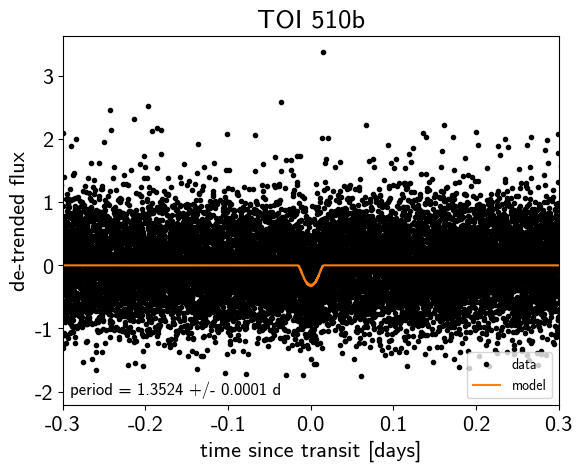

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

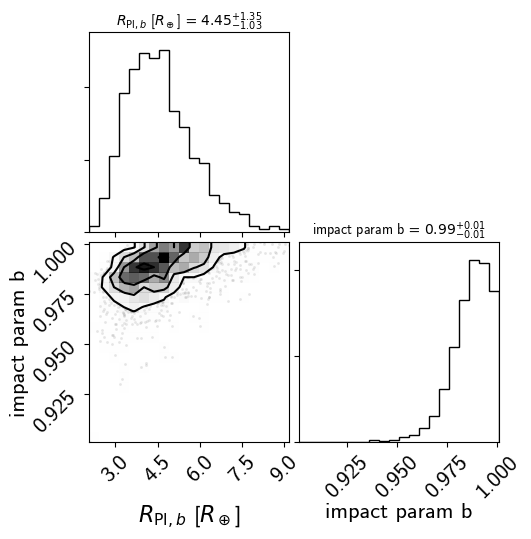

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

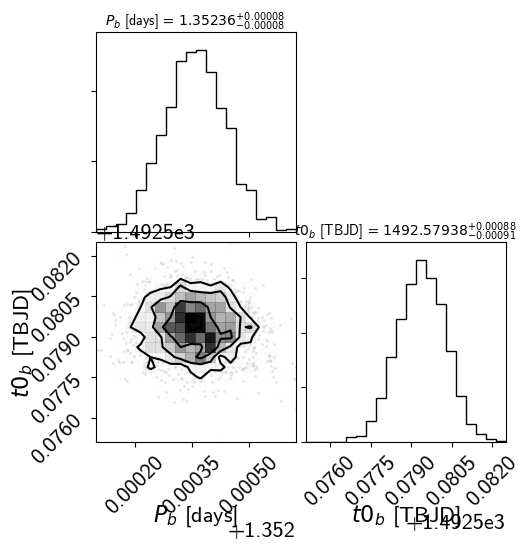

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

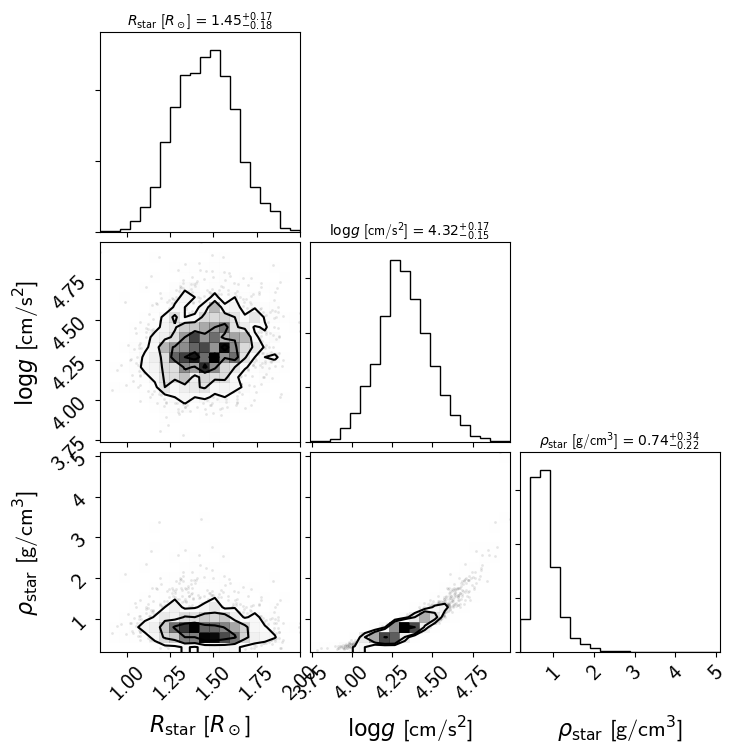

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3